<a href="https://colab.research.google.com/github/mzffreyvazov/ai-experiments/blob/main/dtsu/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno

from scipy import stats
from scipy.stats import rankdata, norm

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:

df = pd.read_csv('train.csv')

In [ ]:
df.sample(20)['target']
# print("\nValue counts:\n", df['target'].value_counts())

331944    1
194705    0
504231    0
273951    1
37196     0
204972    0
419138    0
382711    0
386943    0
168047    1
119859    0
200475    0
213815    0
520378    0
590891    0
255802    1
474642    0
140692    1
157051    0
406284    0
Name: target, dtype: int64

In [ ]:
df.columns

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
       'target'],
      dtype='object')

In [ ]:
df.shape

(600000, 25)

In [ ]:
df['target'].unique()

array([0, 1], dtype=int64)

In [ ]:
df['target'].value_counts()

target
0    487677
1    112323
Name: count, dtype: int64

In [ ]:
df.describe()

,id,bin_0,bin_1,bin_2,ord_0,day,month,target
count,600000.000000,582106.000000,581997.000000,582070.000000,581712.000000,582048.000000,582012.000000,600000.000000
mean,299999.500000,0.092301,0.185532,0.278704,1.948224,4.112767,6.371317,0.187205
std,173205.225094,0.289451,0.388729,0.448362,0.853904,2.034430,3.458959,0.390076
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,149999.750000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000
50%,299999.500000,0.000000,0.000000,0.000000,2.000000,5.000000,6.000000,0.000000
75%,449999.250000,0.000000,0.000000,1.000000,3.000000,6.000000,8.000000,0.000000
max,599999.000000,1.000000,1.000000,1.000000,3.000000,7.000000,12.000000,1.000000


## Feature overview

In [ ]:

feature_summary = pd.DataFrame({
    'missing_rate': df.isna().mean(),
    'unique_values': df.nunique(),
    'dtype': df.dtypes
})

feature_groups = {
    'binary': [col for col in df.columns if col.startswith('bin_')],
    'nominal': [col for col in df.columns if col.startswith('nom_')],
    'ordinal': ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5'],
    'other': ['id', 'day', 'month', 'target']
}


for group, cols in feature_groups.items():
    print(f"\n{group.upper()} FEATURES:")
    print(feature_summary.loc[cols])


BINARY FEATURES:
       missing_rate  unique_values    dtype
bin_0      0.029823              2  float64
bin_1      0.030005              2  float64
bin_2      0.029883              2  float64
bin_3      0.030023              2   object
bin_4      0.030078              2   object

NOMINAL FEATURES:
       missing_rate  unique_values   dtype
nom_0      0.030420              3  object
nom_1      0.030260              6  object
nom_2      0.030058              6  object
nom_3      0.030202              6  object
nom_4      0.030058              4  object
nom_5      0.029630           1220  object
nom_6      0.030218           1519  object
nom_7      0.030005            222  object
nom_8      0.029592            222  object
nom_9      0.030122           2218  object

ORDINAL FEATURES:
       missing_rate  unique_values    dtype
ord_0      0.030480              3  float64
ord_1      0.030068              5   object
ord_2      0.030125              6   object
ord_3      0.029860            

## Handling missing values

<Axes: >

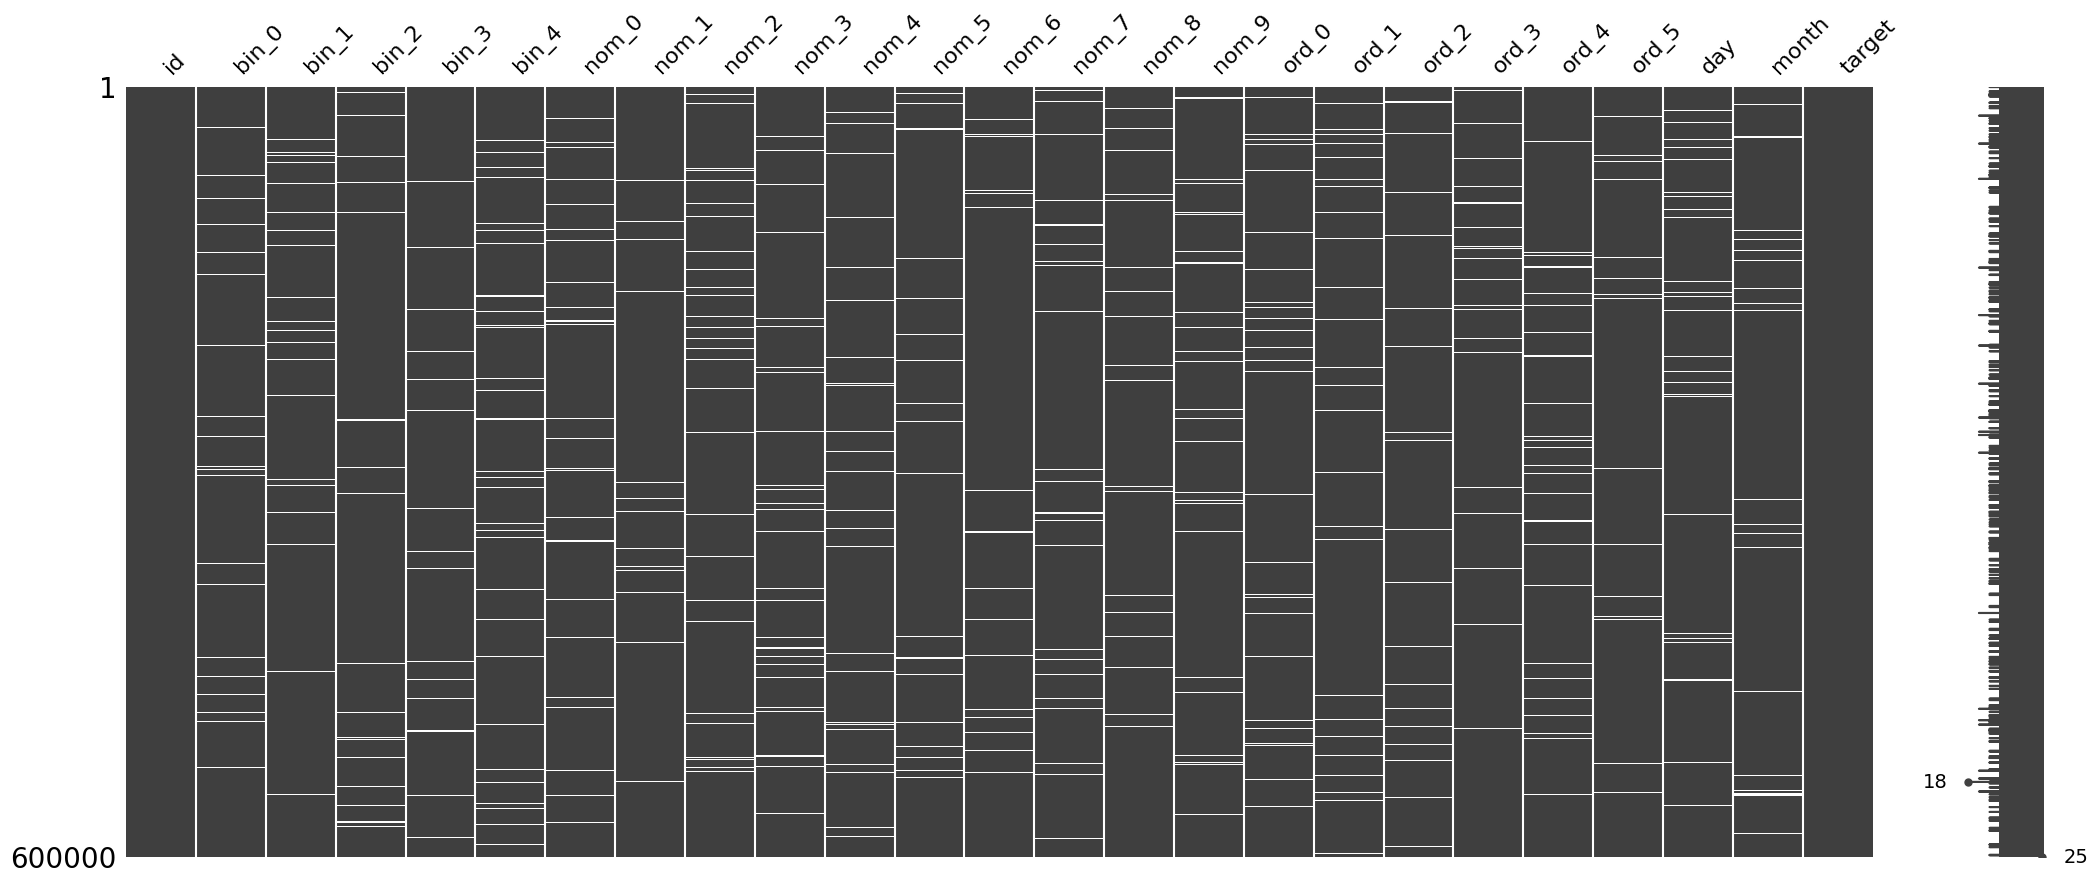

In [ ]:
msno.matrix(df)

In [ ]:
pd.DataFrame(df.isna().sum(axis=0)*100/df.shape[0], columns=['missing percent']).sort_values('missing percent', ascending=False)
missing_info = pd.DataFrame({
    'missing count': df.isna().sum(axis=0),
    'missing percent': df.isna().sum(axis=0)*100/df.shape[0]
}).sort_values('missing percent', ascending=False)

missing_info[~missing_info.index.isin(['day', 'id', 'month', 'target'])].sort_index()

,missing count,missing percent
bin_0,17894,2.982333
bin_1,18003,3.000500
bin_2,17930,2.988333
bin_3,18014,3.002333
bin_4,18047,3.007833
nom_0,18252,3.042000
nom_1,18156,3.026000
nom_2,18035,3.005833
nom_3,18121,3.020167
nom_4,18035,3.005833


In [ ]:
binary_features = [col for col in df.columns if col.startswith('bin_')]
nominal_features = [col for col in df.columns if col.startswith('nom_')]
ordinal_features = [col for col in df.columns if col.startswith('ord_')]
binary_features, nominal_features, ordinal_features

(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4'],
 ['nom_0',
  'nom_1',
  'nom_2',
  'nom_3',
  'nom_4',
  'nom_5',
  'nom_6',
  'nom_7',
  'nom_8',
  'nom_9'],
 ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5'])

## Mode imputation for binary features (bin_*)

In [ ]:
def impute_binary_features(df, binary_features):
    df_imputed = df.copy()

    mode_imputer = SimpleImputer(strategy='most_frequent')

    mode_values = {}

    for col in binary_features:
        if df[col].dtype == 'object':
            unique_vals = df[col].dropna().unique()
            mapping = {val: idx for idx, val in enumerate(unique_vals)}

            df_imputed[col] = df[col].map(mapping)
            df_imputed[col] = mode_imputer.fit_transform(df_imputed[[col]])

            reverse_mapping = {idx: val for val, idx in mapping.items()}
            df_imputed[col] = df_imputed[col].map(reverse_mapping)

        else:
            df_imputed[col] = mode_imputer.fit_transform(df[[col]])

        mode_values[col] = df[col].mode()[0]

    return df_imputed, mode_values

In [ ]:
df_imputed, mode_values = impute_binary_features(df, binary_features)
df_imputed[binary_features].head()

,bin_0,bin_1,bin_2,bin_3,bin_4
0,0.0,0.0,0.0,F,N
1,1.0,1.0,0.0,F,Y
2,0.0,1.0,0.0,F,N
3,0.0,0.0,0.0,F,N
4,0.0,0.0,0.0,T,N


In [ ]:
df_imputed[binary_features].isnull().sum()

bin_0    0
bin_1    0
bin_2    0
bin_3    0
bin_4    0
dtype: int64

<Axes: >

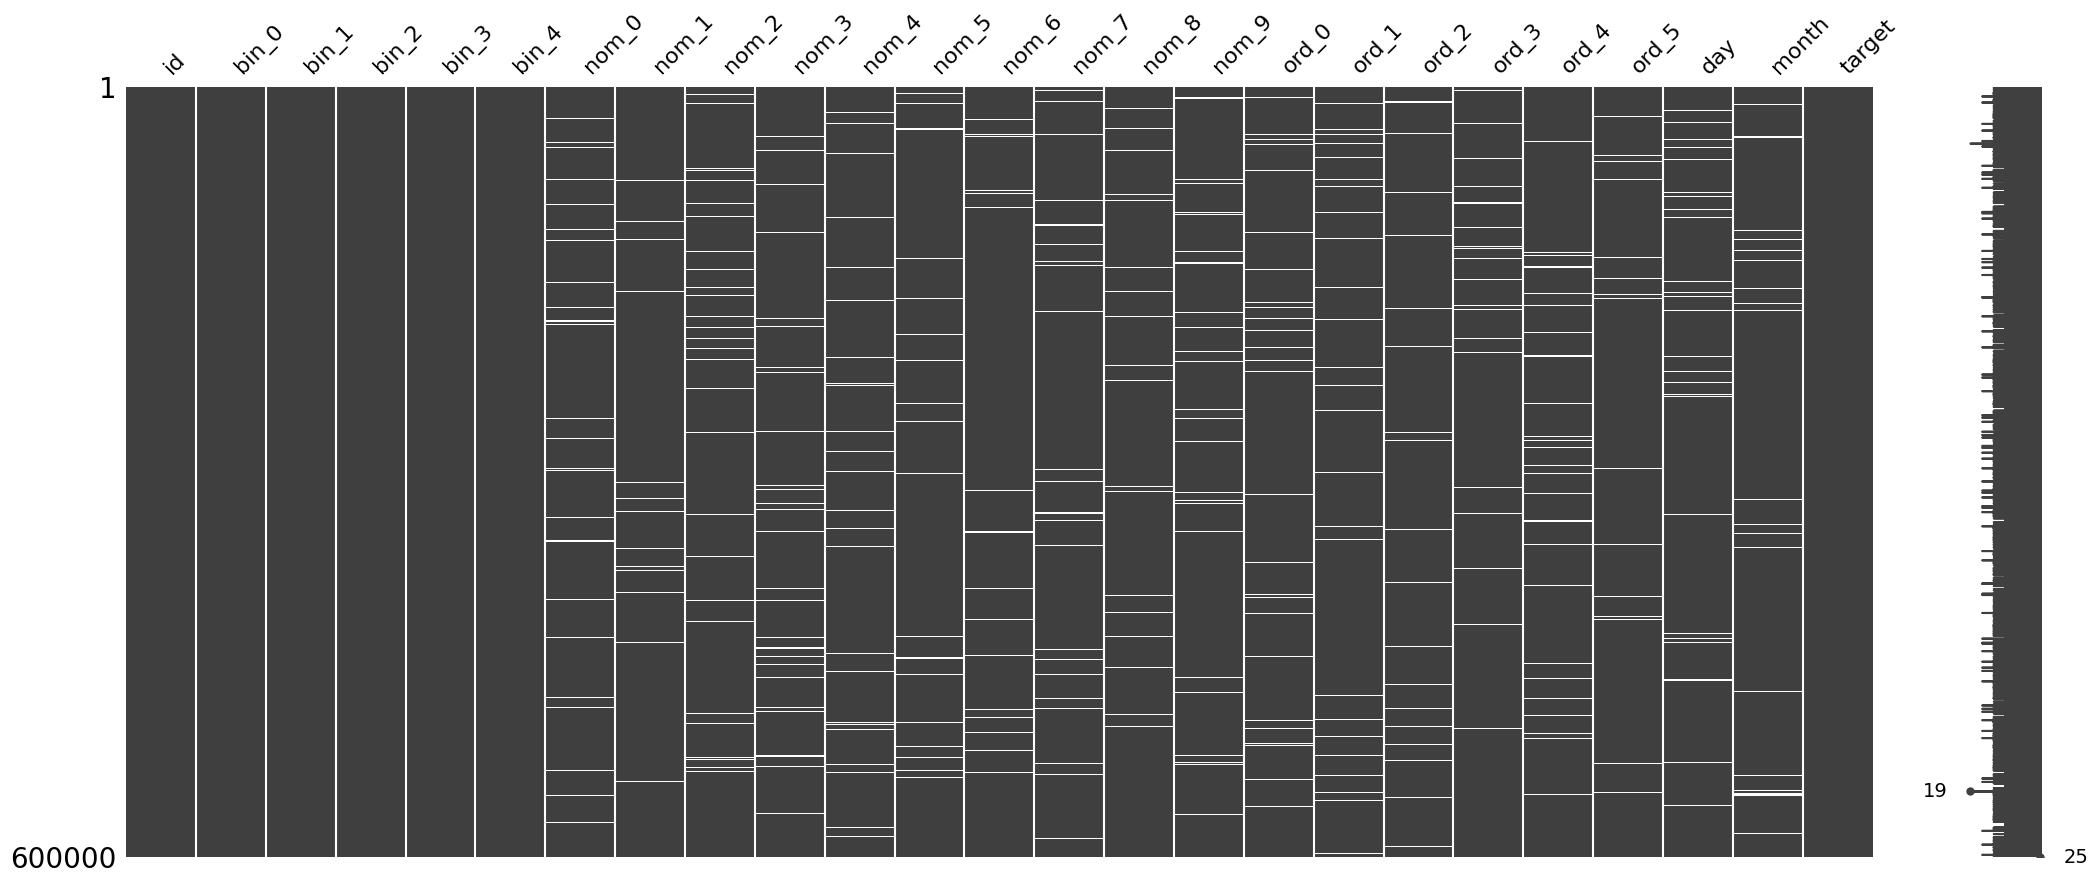

In [ ]:
msno.matrix(df_imputed)

## Mode imputation for nom features with low cardinality and iterative imputation for high cardinality

In [ ]:
def impute_nominal_features_optimized(df, low_cardinality_cols, high_cardinality_cols):
    df_imputed = df.copy()

    # low cardinality features - simple most-frequent imputation
    mode_imputer = SimpleImputer(strategy='most_frequent')
    df_imputed[low_cardinality_cols] = mode_imputer.fit_transform(df[low_cardinality_cols])

    # high cardinality features
    for col in high_cardinality_cols:
        le = LabelEncoder()
        non_missing = df[col].dropna()
        le.fit(non_missing)

        df_imputed.loc[df[col].notna(), col] = le.transform(non_missing)

        iter_imputer = IterativeImputer(
            estimator=RandomForestRegressor(
                n_estimators=10,
                max_depth=5,
                min_samples_split=10
            ),
            max_iter=5,
            random_state=42,
            initial_strategy='most_frequent'
        )

        col_data = df_imputed[col].values.reshape(-1, 1)
        imputed_values = iter_imputer.fit_transform(col_data)

        imputed_values = np.clip(np.round(imputed_values), 0, len(le.classes_) - 1)

        df_imputed.loc[df[col].isna(), col] = le.inverse_transform(imputed_values[df[col].isna()].astype(int).ravel())

    return df_imputed


In [ ]:
low_cardinality_cols = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']
high_cardinality_cols = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
df_nominal_imputed = impute_nominal_features_optimized(df_imputed,
                                                           low_cardinality_cols,
                                                           high_cardinality_cols)

<Axes: >

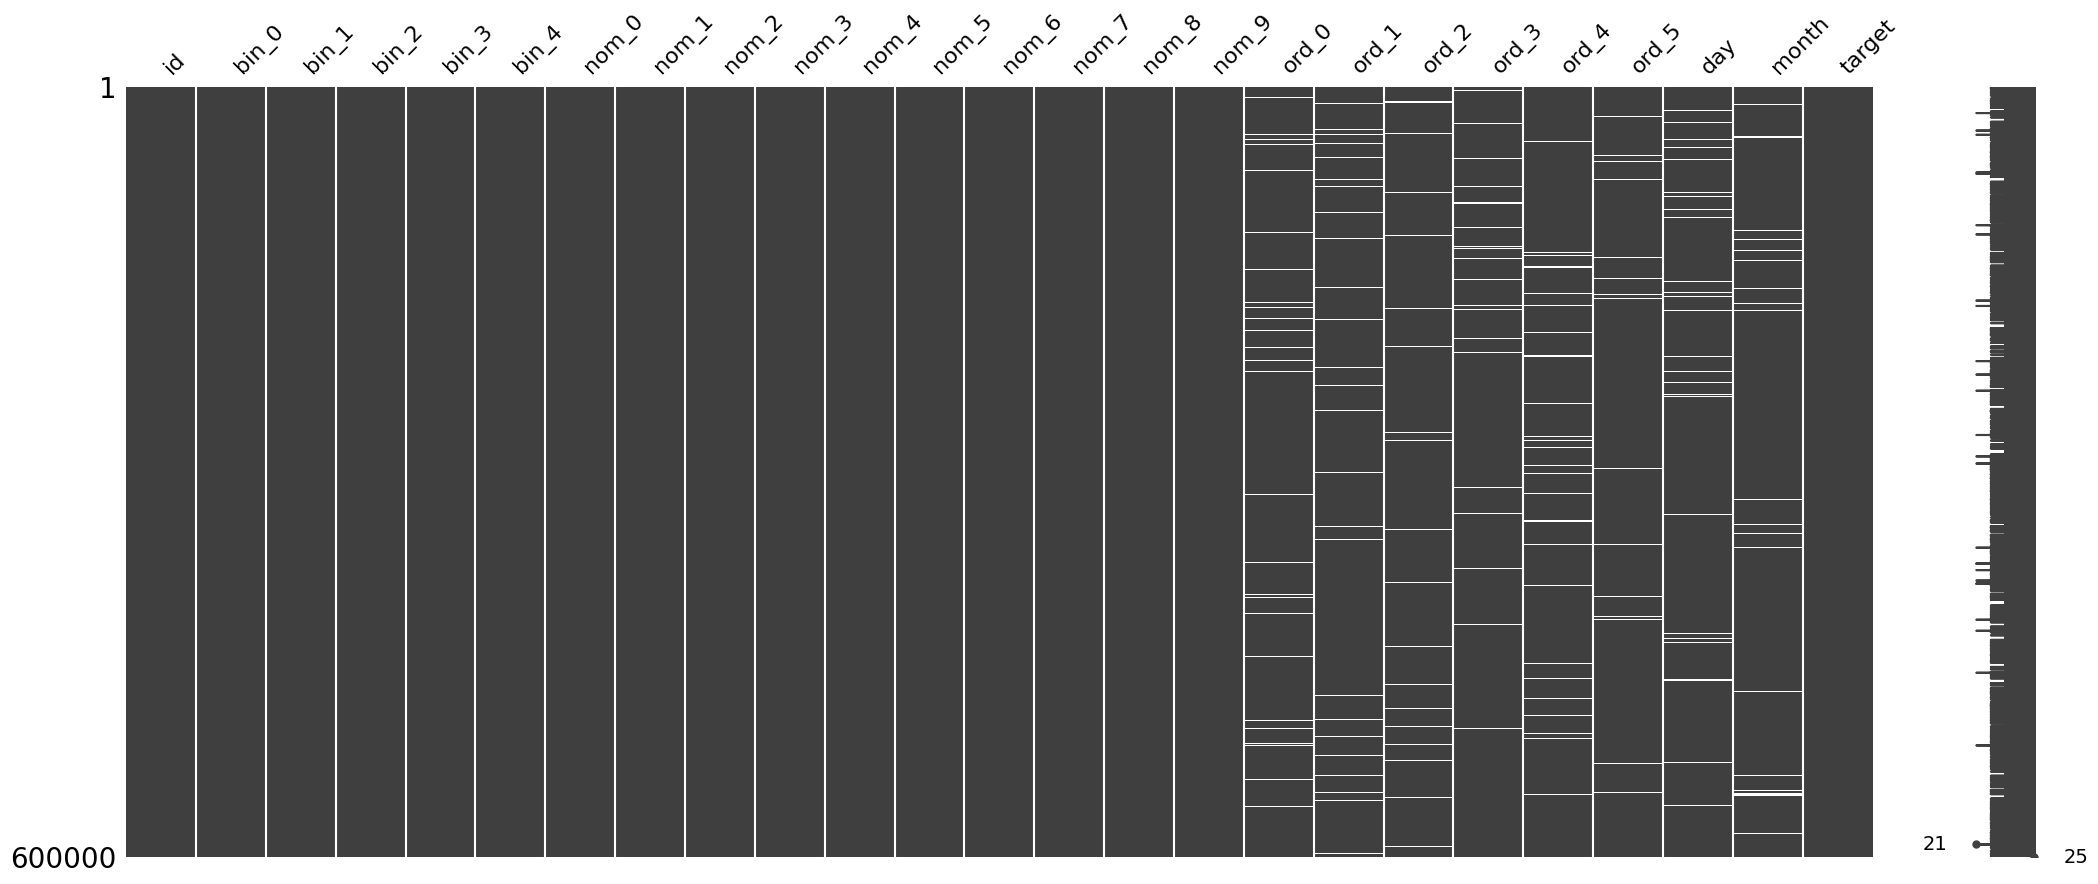

In [ ]:
msno.matrix(df_nominal_imputed)

In [ ]:
def impute_ordinal_features(df, low_cardinality_cols, high_cardinality_cols):
    """
    Impute ordinal features using simple imputation for low cardinality features
    and iterative imputation for high cardinality features.
    """
    df_imputed = df.copy()

    # low cardinality features
    mode_imputer = SimpleImputer(strategy='most_frequent')
    df_imputed[low_cardinality_cols] = mode_imputer.fit_transform(df[low_cardinality_cols])

    # high cardinality features - iterative imputation
    for col in high_cardinality_cols:
        le = LabelEncoder()
        non_missing = df[col].dropna()
        le.fit(non_missing)

        df_imputed.loc[df[col].notna(), col] = le.transform(non_missing)

        iter_imputer = IterativeImputer(
            estimator=RandomForestRegressor(
                n_estimators=10,
                max_depth=5,
                min_samples_split=10
            ),
            max_iter=5,
            random_state=42,
            initial_strategy='most_frequent'
        )

        col_data = df_imputed[col].values.reshape(-1, 1)
        imputed_values = iter_imputer.fit_transform(col_data)

        imputed_values = np.clip(np.round(imputed_values), 0, len(le.classes_) - 1)

        df_imputed.loc[df[col].isna(), col] = le.inverse_transform(imputed_values[df[col].isna()].astype(int).ravel())

    return df_imputed

In [ ]:
low_ord = ['ord_0', 'ord_1', 'ord_2']
high_ord = ['ord_3', 'ord_4', 'ord_5']
df_ordinal_imputed = impute_ordinal_features(df_nominal_imputed, low_ord, high_ord)

In [ ]:
df_ordinal_imputed[ordinal_features].isnull().sum()

ord_0    0
ord_1    0
ord_2    0
ord_3    0
ord_4    0
ord_5    0
dtype: int64

<Axes: >

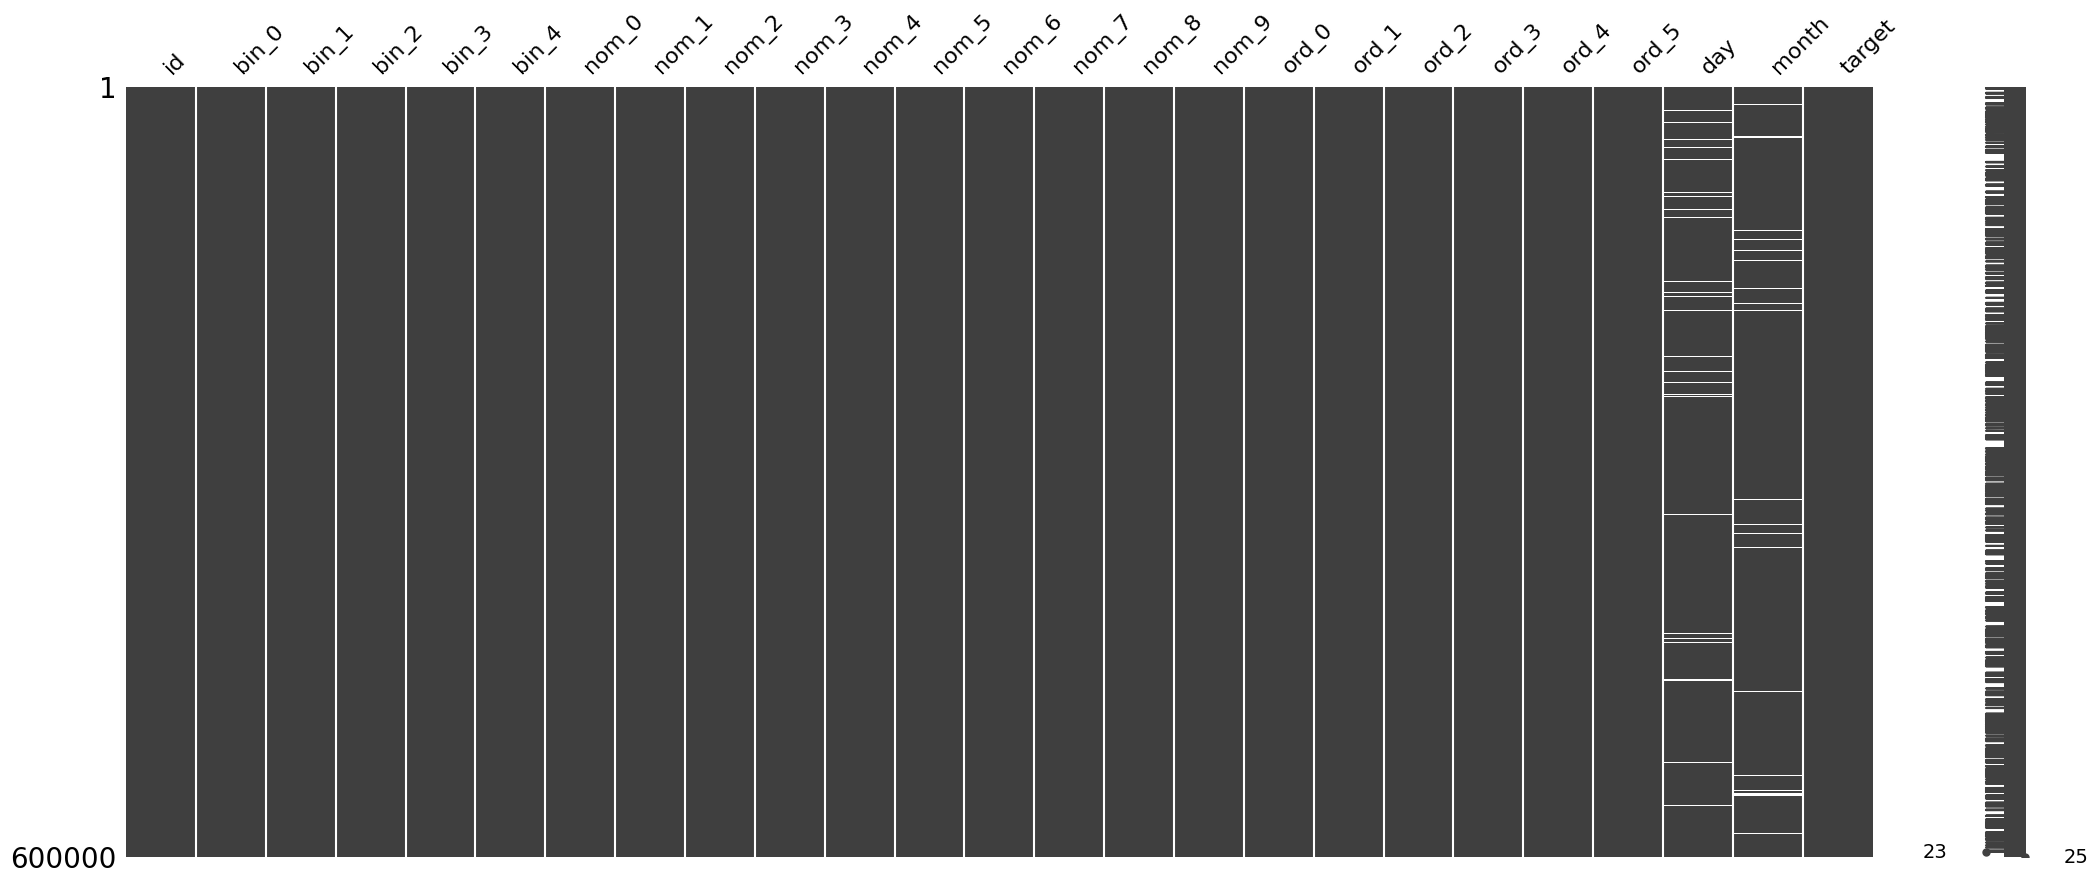

In [ ]:
msno.matrix(df_ordinal_imputed)

## Mode imputation for day and month columns

### Mode imputation for day column

In [ ]:
def impute_day(df):
    """Impute missing values in day column using mode"""
    df_imputed = df.copy()

    mode_imputer = SimpleImputer(strategy='most_frequent')

    day_imputed = mode_imputer.fit_transform(df[['day']])
    df_imputed.loc[df['day'].isna(), 'day'] = day_imputed[df['day'].isna()]

    return df_imputed

In [ ]:
df_day_imputed = impute_day(df_ordinal_imputed)

In [ ]:
df_day_imputed["day"].isnull().sum()

0

<Axes: >

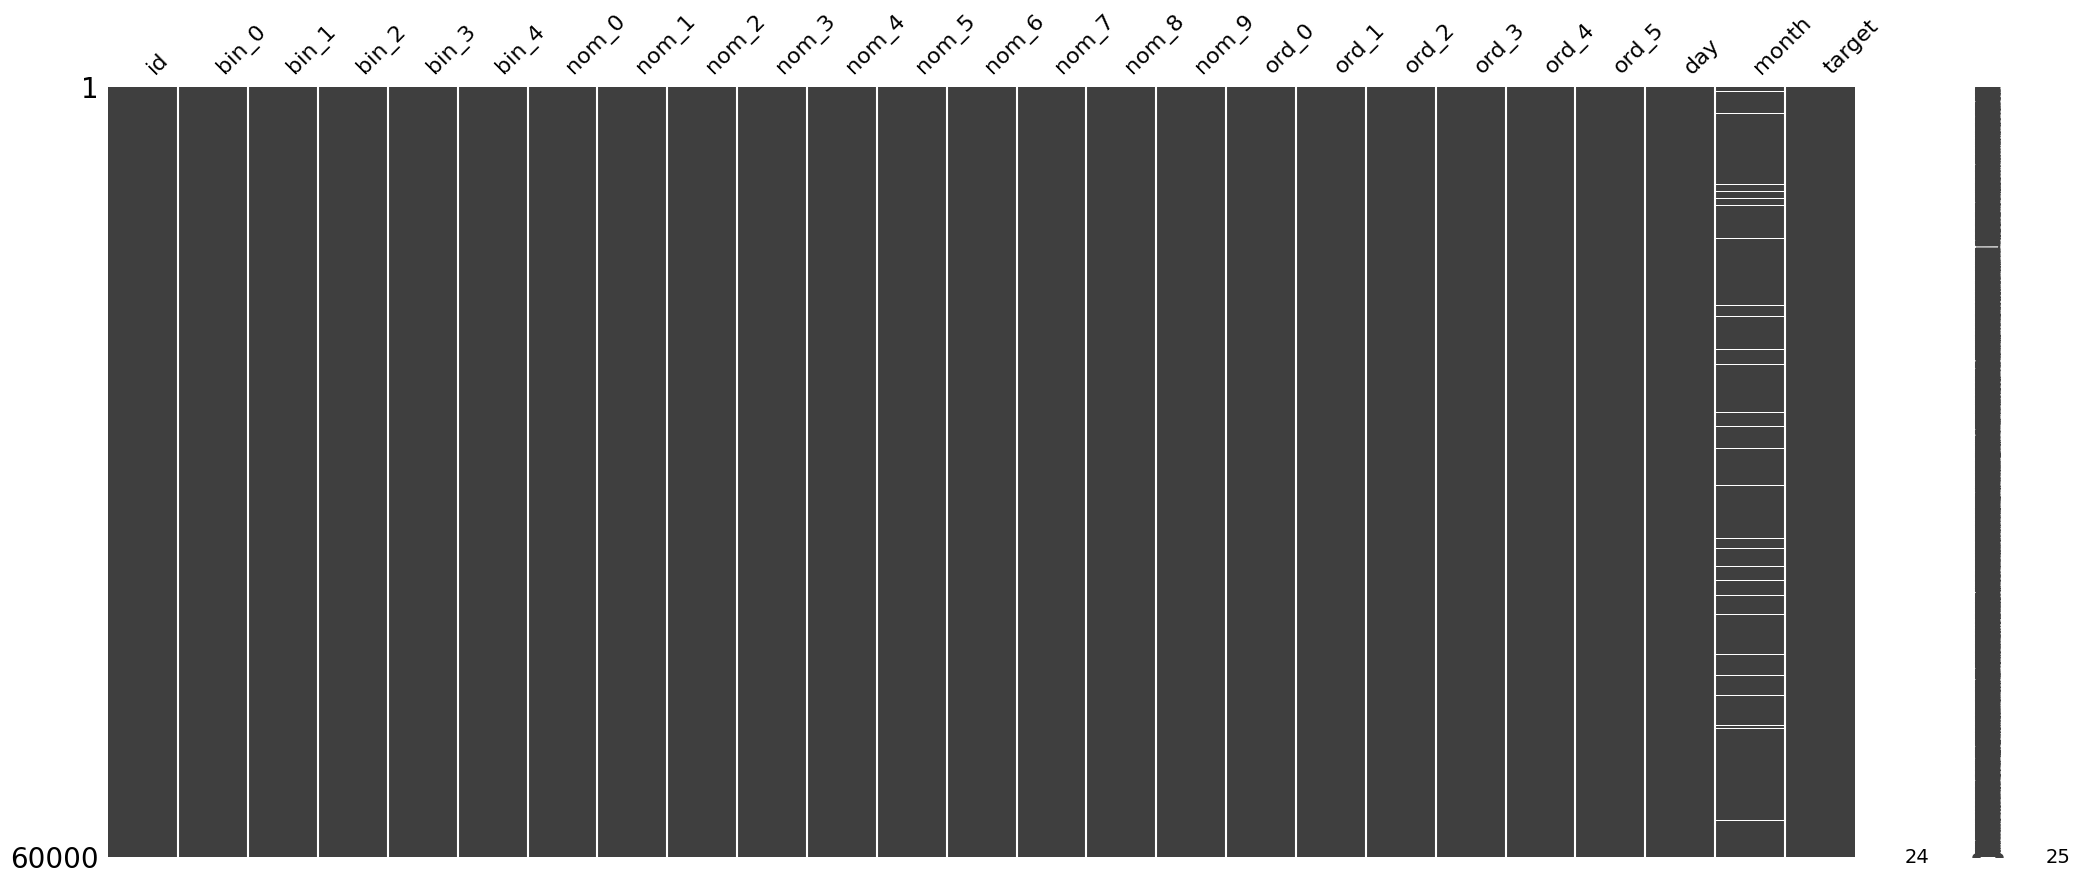

In [ ]:
sample_size = 60000
df_sample = df_day_imputed.sample(n=sample_size, random_state=42)
msno.matrix(df_sample)

### Mode imputation for month column

In [ ]:
def impute_month(df):
    """Impute missing values in month column using mode"""
    df_imputed = df.copy()

    mode_imputer = SimpleImputer(strategy='most_frequent')

    month_imputed = mode_imputer.fit_transform(df[['month']])

    df_imputed.loc[df['month'].isna(), 'month'] = month_imputed[df['month'].isna()]

    return df_imputed

In [ ]:
df_month_imputed = impute_month(df_day_imputed)

In [ ]:
df_month_imputed["month"].isnull().sum()

0

<Axes: >

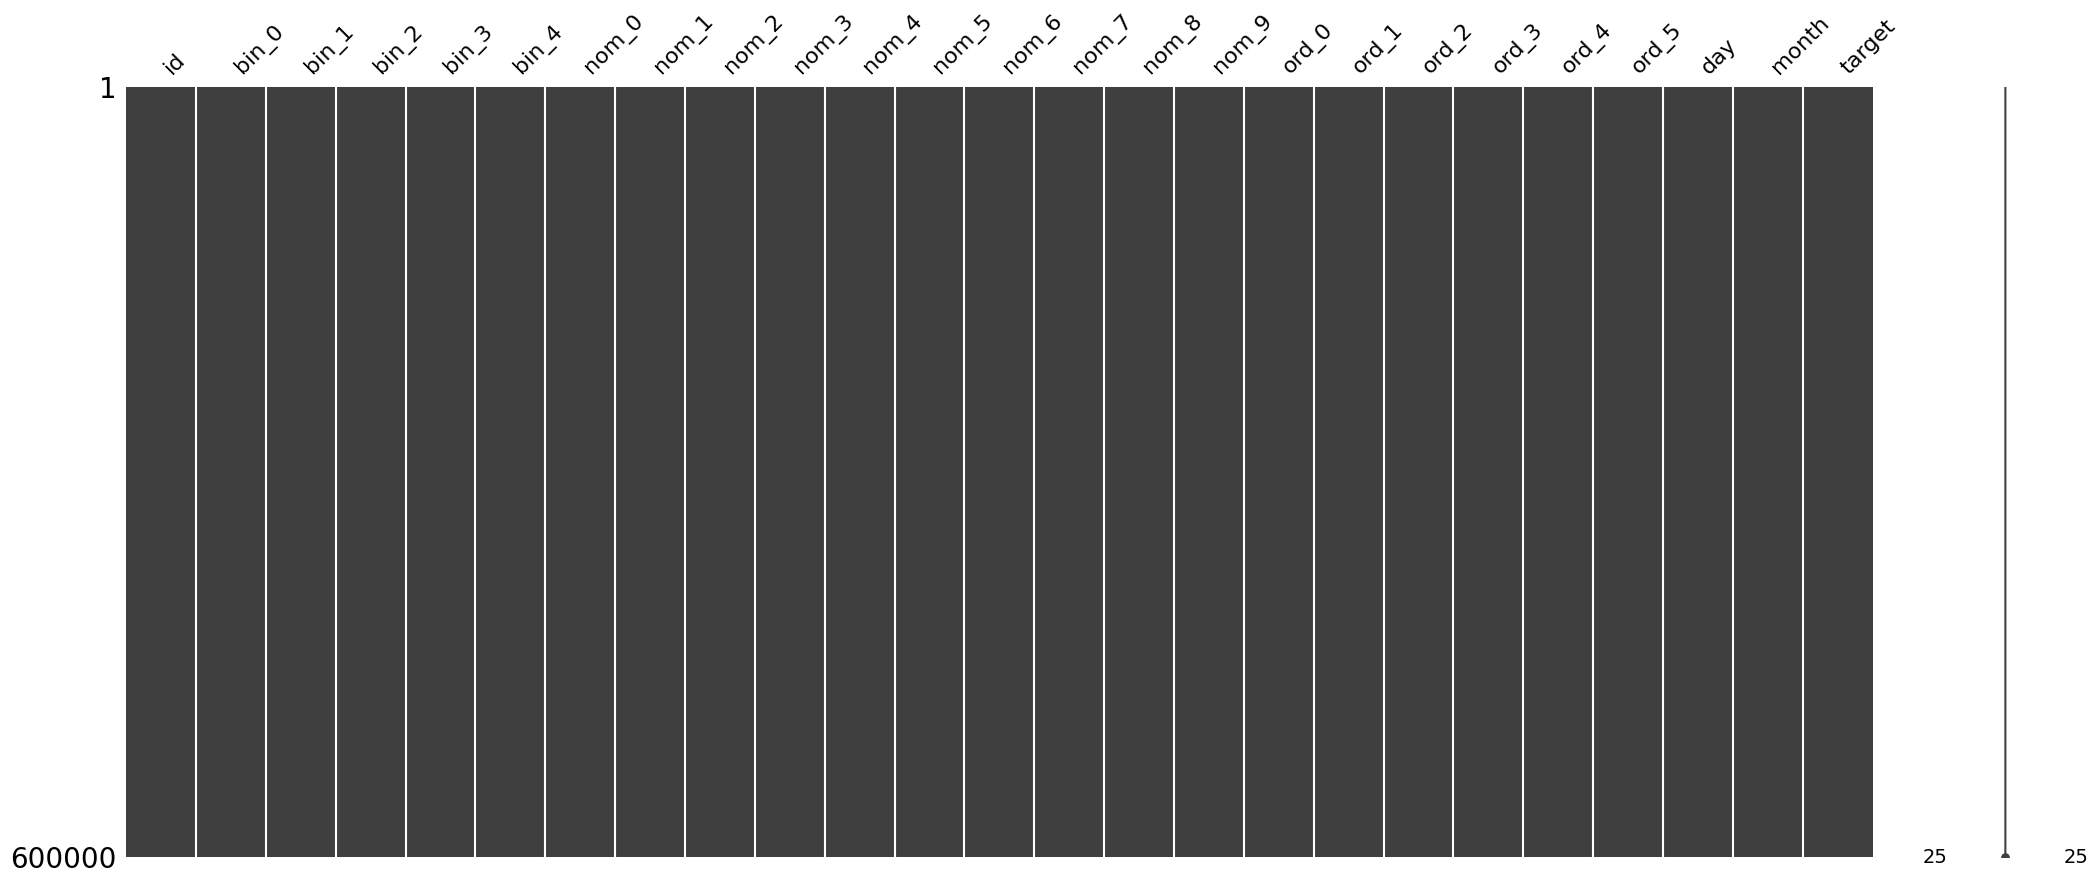

In [ ]:
msno.matrix(df_month_imputed)

In [ ]:
train_final = df_month_imputed.copy()

## Doing the imputations for the test.csv

In [ ]:
test_df = pd.read_csv('test.csv')

<Axes: >

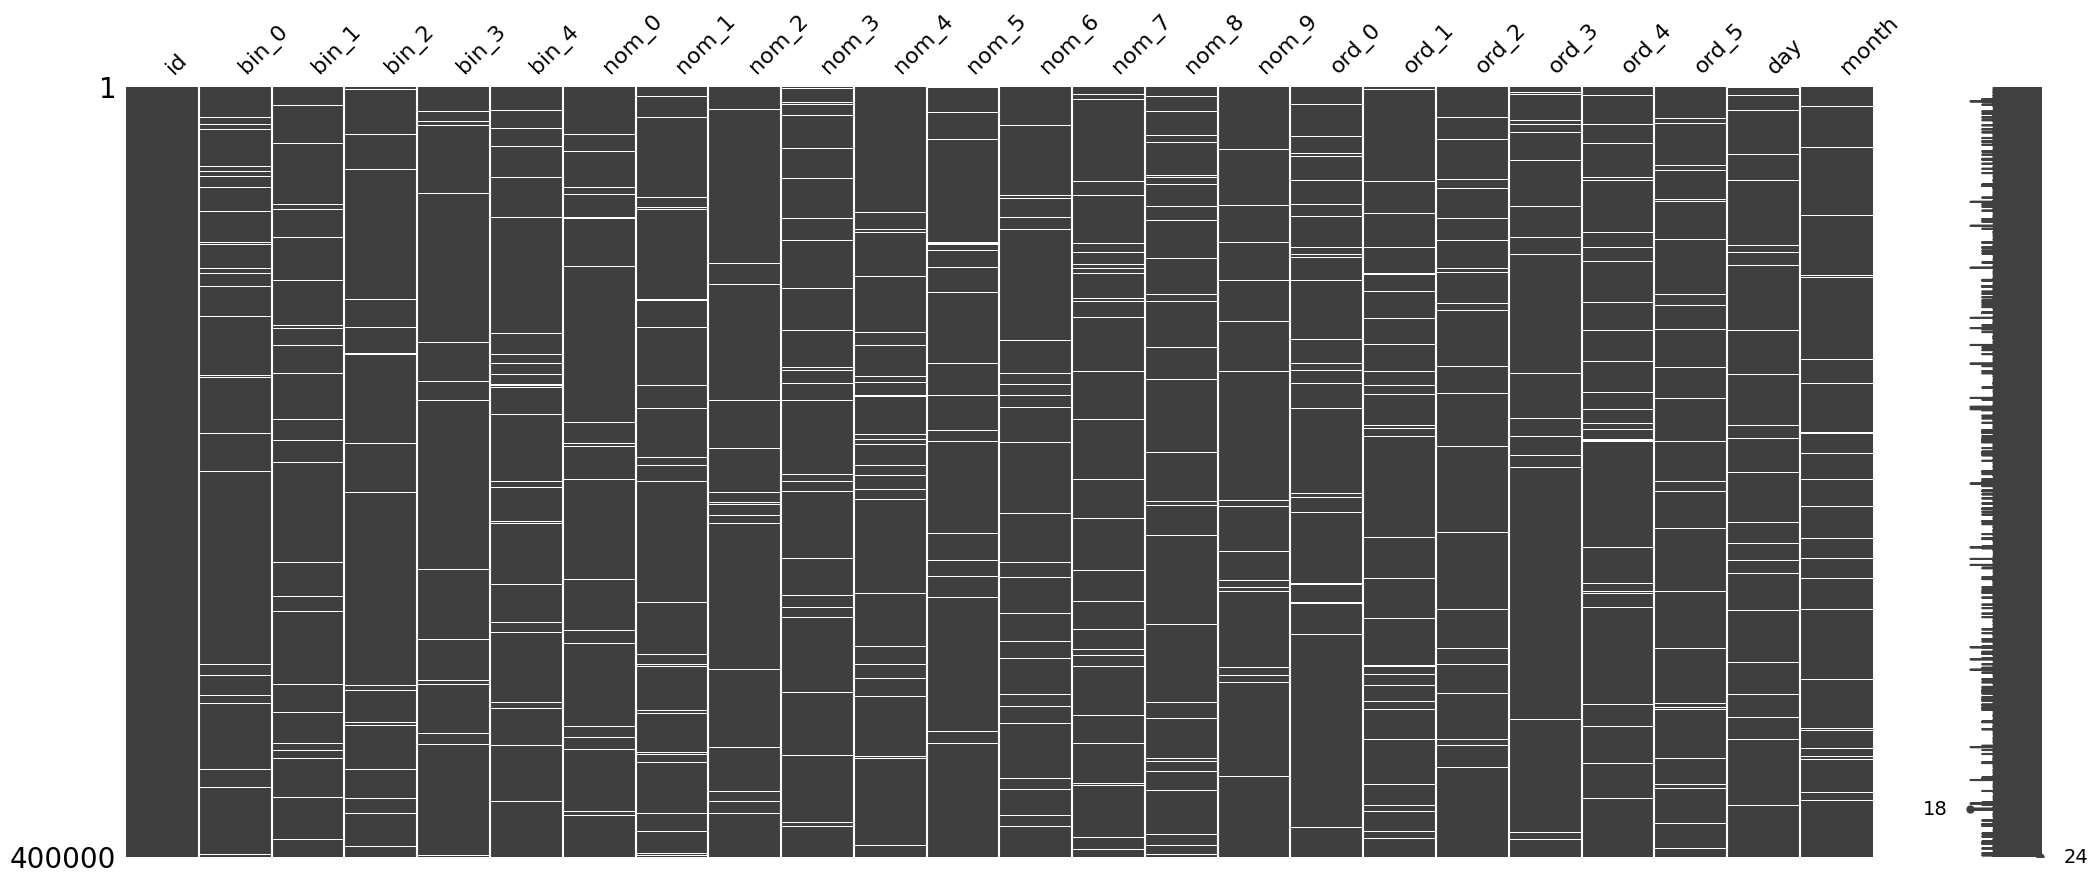

In [ ]:
msno.matrix(test_df)

In [ ]:
test_df_bin_imputed, mode_values = impute_binary_features(test_df, binary_features)
test_df_bin_imputed[binary_features].head()

,bin_0,bin_1,bin_2,bin_3,bin_4
0,0.0,0.0,0.0,F,Y
1,0.0,0.0,0.0,F,Y
2,0.0,0.0,0.0,F,Y
3,1.0,0.0,0.0,F,N
4,0.0,0.0,1.0,F,Y


<Axes: >

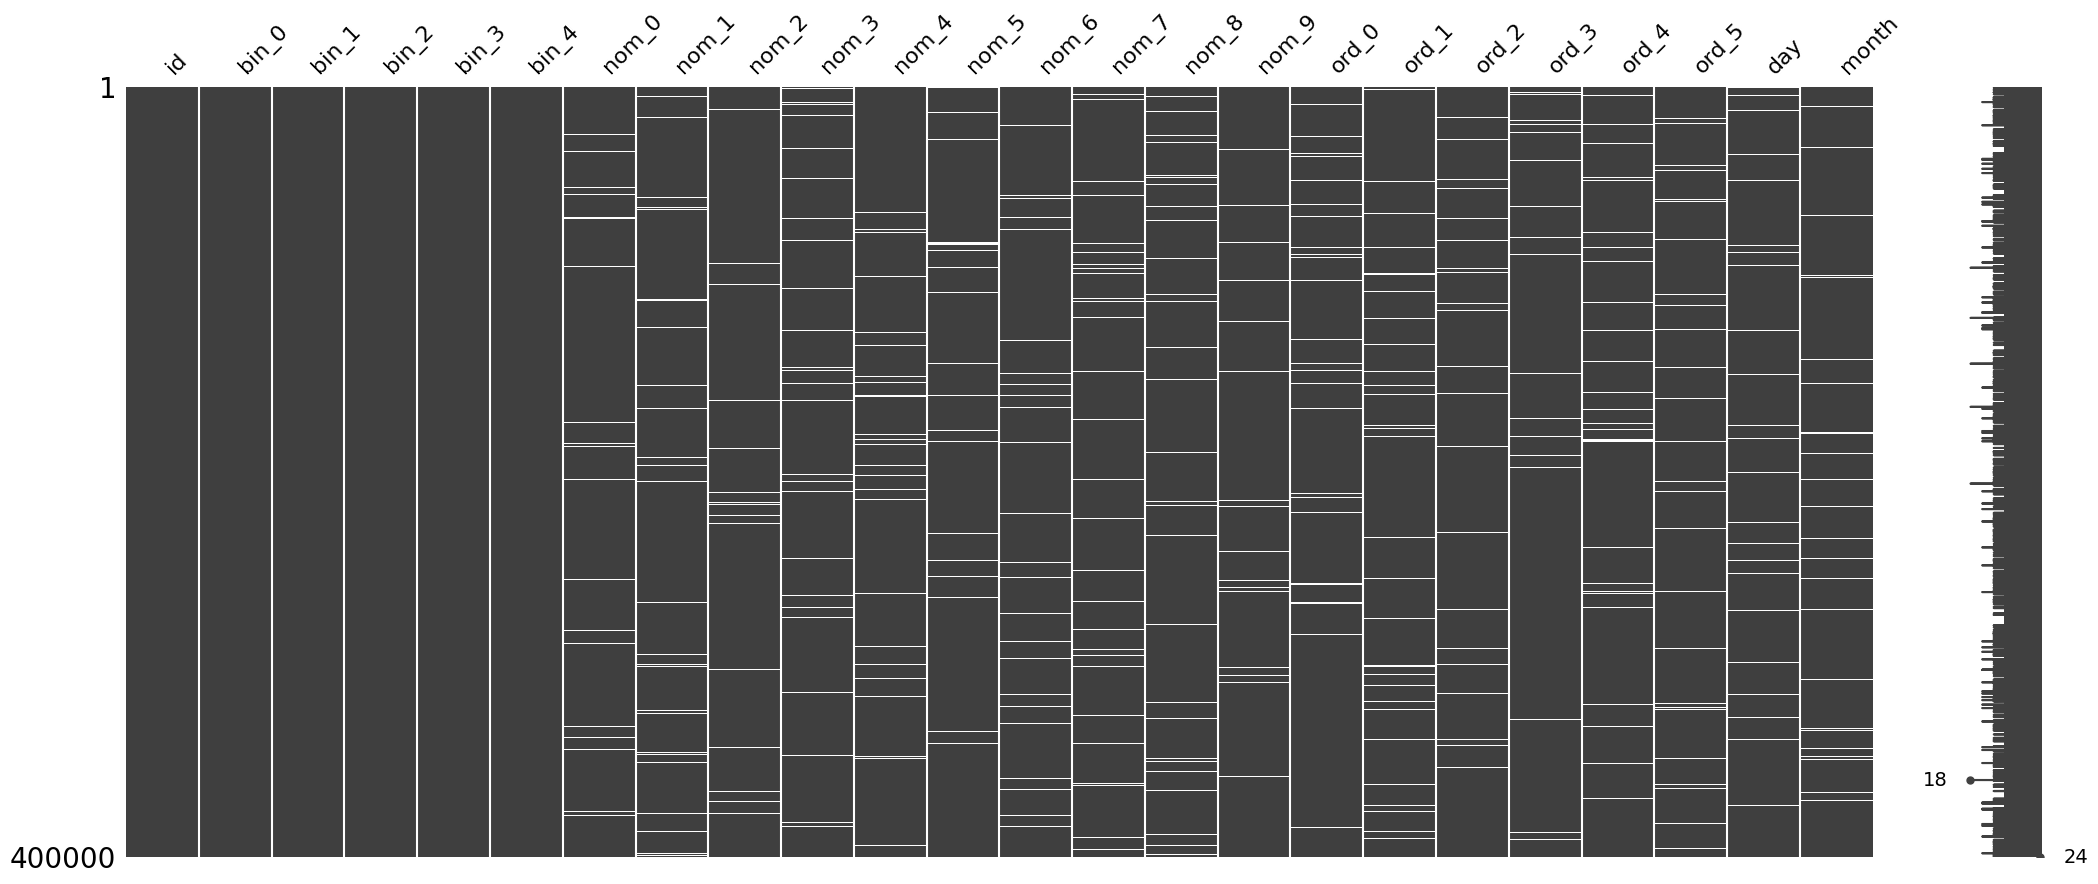

In [ ]:
msno.matrix(test_df_bin_imputed)

In [ ]:
tet_df_nominal_imputed = impute_nominal_features_optimized(test_df_bin_imputed,
                                                           low_cardinality_cols,
                                                           high_cardinality_cols)

<Axes: >

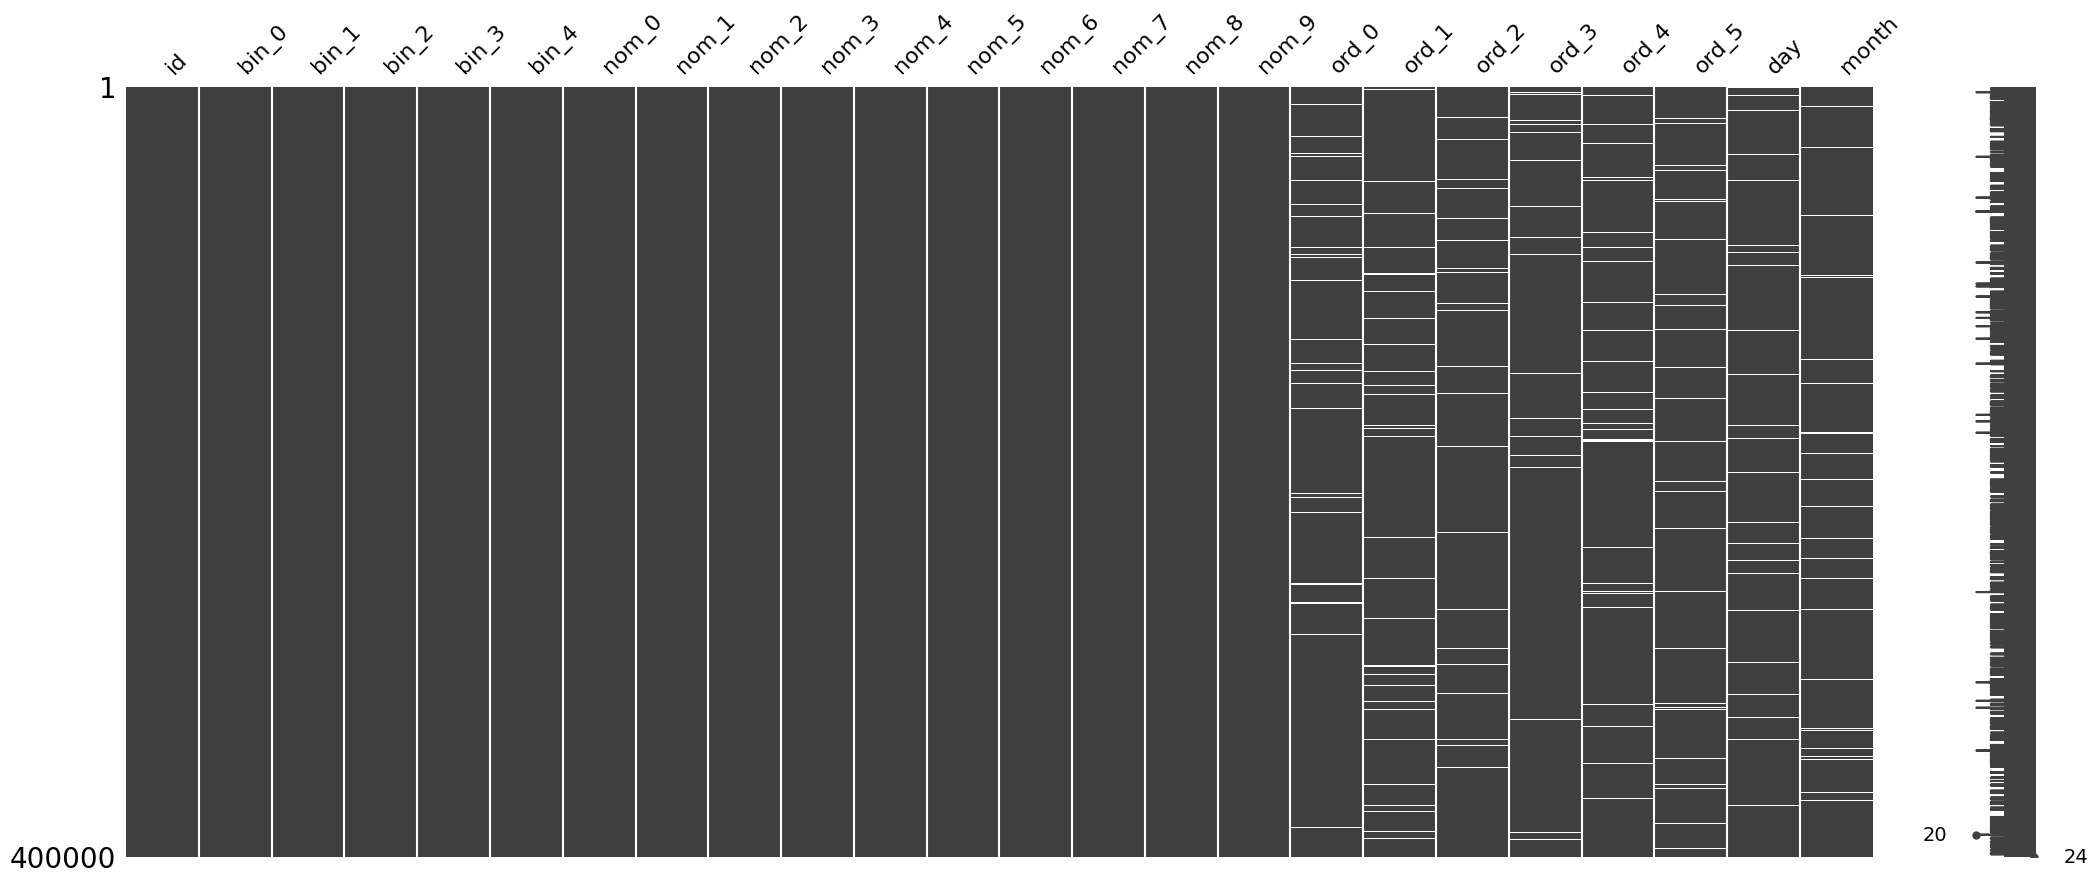

In [ ]:
msno.matrix(tet_df_nominal_imputed)

In [ ]:
test_df_ordinal_imputed = impute_ordinal_features(tet_df_nominal_imputed, low_ord, high_ord)

In [ ]:
test_df_ordinal_imputed[ordinal_features].isnull().sum()

ord_0    0
ord_1    0
ord_2    0
ord_3    0
ord_4    0
ord_5    0
dtype: int64

In [ ]:
test_df_day_imputed = impute_day(test_df_ordinal_imputed)

<Axes: >

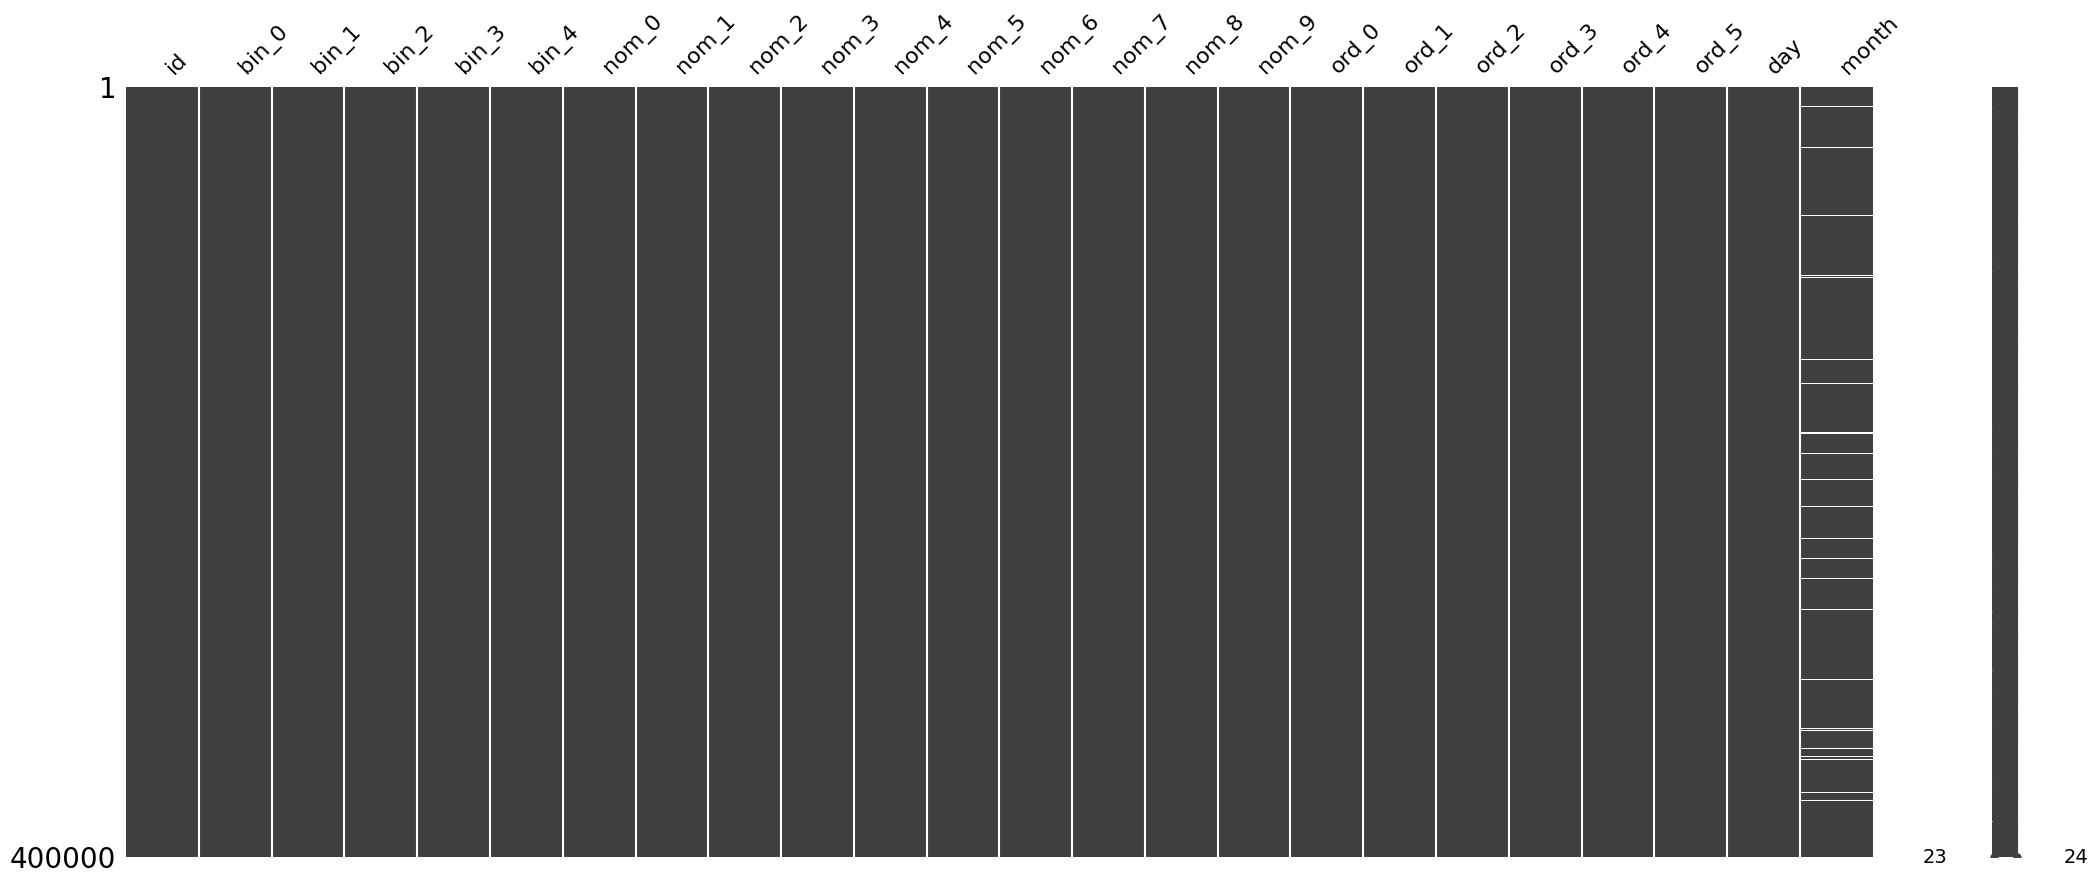

In [ ]:
msno.matrix(test_df_day_imputed)

In [ ]:
test_df_month_imputed = impute_month(test_df_day_imputed)

<Axes: >

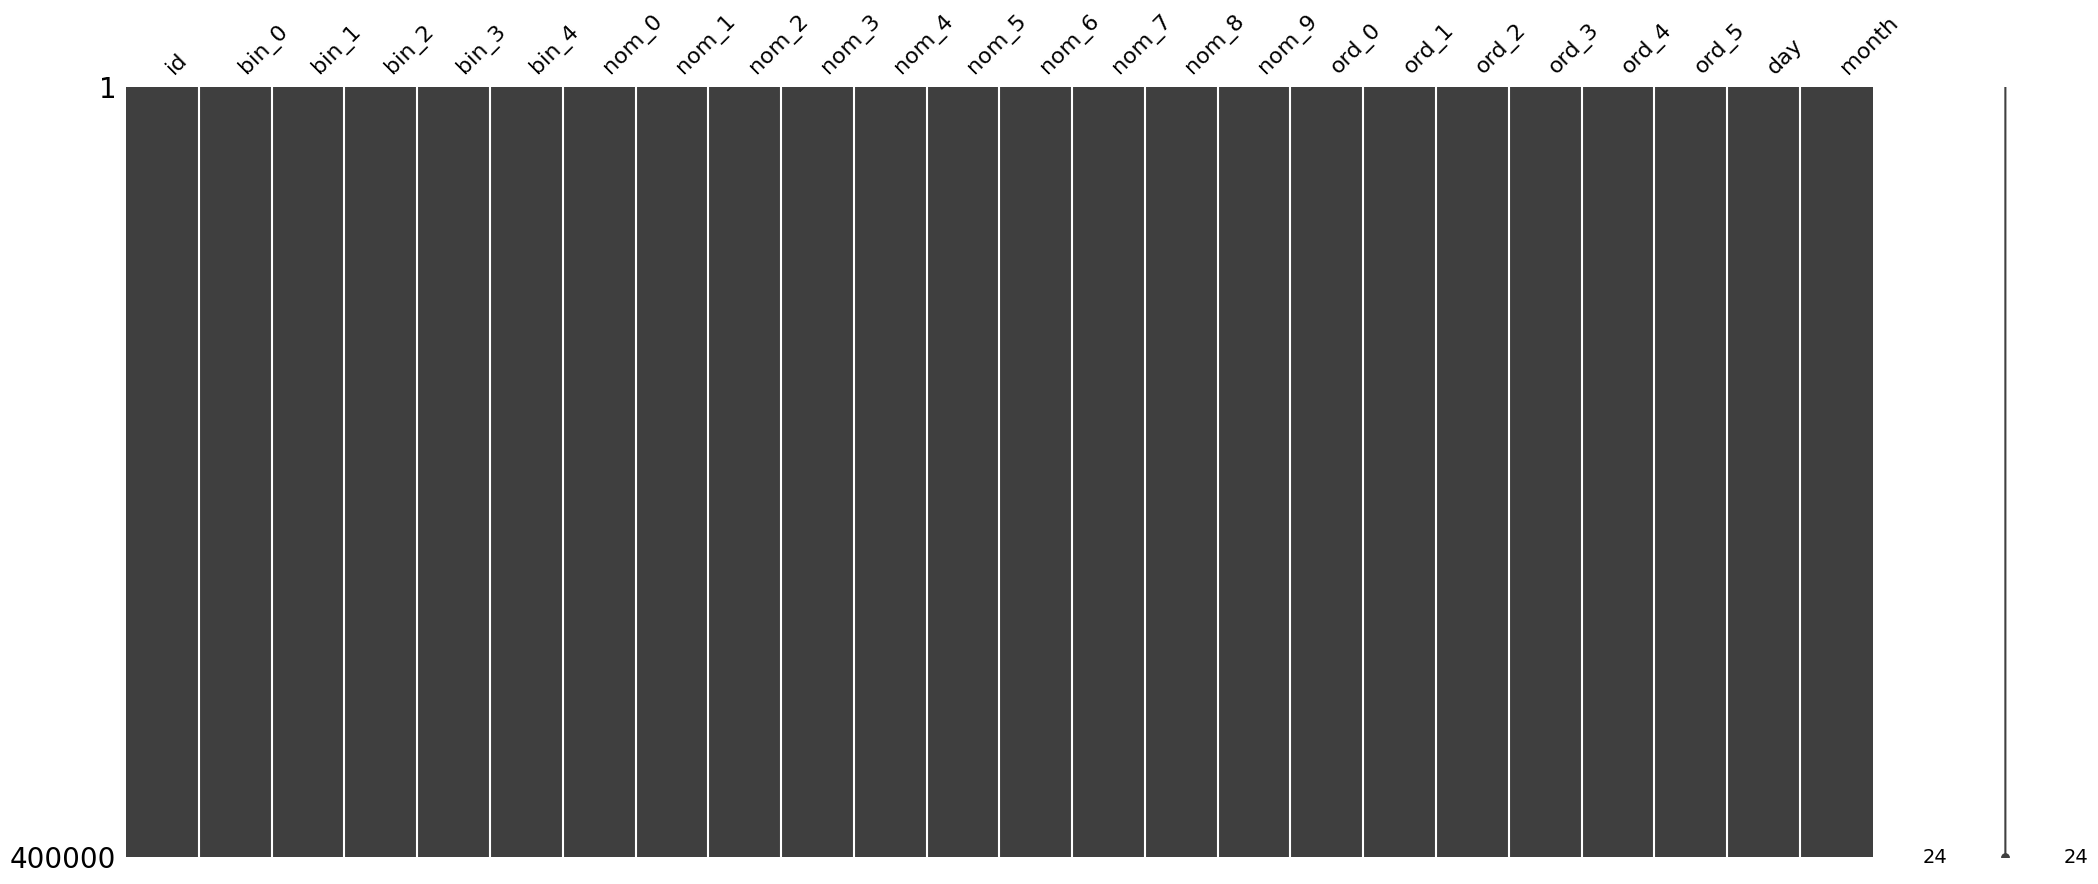

In [ ]:
msno.matrix(test_df_month_imputed)

In [ ]:
test_final = test_df_month_imputed.copy()

In [ ]:
train_final.isnull().sum()

id        0
bin_0     0
bin_1     0
bin_2     0
bin_3     0
bin_4     0
nom_0     0
nom_1     0
nom_2     0
nom_3     0
nom_4     0
nom_5     0
nom_6     0
nom_7     0
nom_8     0
nom_9     0
ord_0     0
ord_1     0
ord_2     0
ord_3     0
ord_4     0
ord_5     0
day       0
month     0
target    0
dtype: int64

In [ ]:
test_final.isnull().sum()

id       0
bin_0    0
bin_1    0
bin_2    0
bin_3    0
bin_4    0
nom_0    0
nom_1    0
nom_2    0
nom_3    0
nom_4    0
nom_5    0
nom_6    0
nom_7    0
nom_8    0
nom_9    0
ord_0    0
ord_1    0
ord_2    0
ord_3    0
ord_4    0
ord_5    0
day      0
month    0
dtype: int64

In [ ]:
train_final['is_train'] = 1
test_final['is_train'] = 0

In [ ]:
train_final["is_train"].value_counts()

is_train
1    600000
Name: count, dtype: int64

In [ ]:
test_final["is_train"].value_counts()

is_train
0    400000
Name: count, dtype: int64

In [ ]:
train_final.sample(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,is_train
429143,429143,0.0,0.0,0.0,F,Y,Blue,Triangle,Lion,Canada,...,3.0,Expert,Warm,13,8,35,1.0,4.0,1,1
71972,71972,0.0,0.0,0.0,T,Y,Red,Square,Lion,India,...,3.0,Contributor,Boiling Hot,4,0,52,3.0,7.0,0,1
281095,281095,0.0,1.0,1.0,T,Y,Blue,Polygon,Hamster,Canada,...,1.0,Expert,Warm,12,16,132,7.0,8.0,0,1
499937,499937,0.0,1.0,0.0,F,N,Blue,Triangle,Hamster,Russia,...,3.0,Novice,Freezing,12,13,112,2.0,11.0,0,1
428582,428582,0.0,0.0,1.0,F,Y,Red,Star,Axolotl,India,...,1.0,Contributor,Hot,1,8,175,5.0,5.0,0,1


In [ ]:
combined_final_df = pd.concat([train_final, test_final], axis=0)

<Axes: >

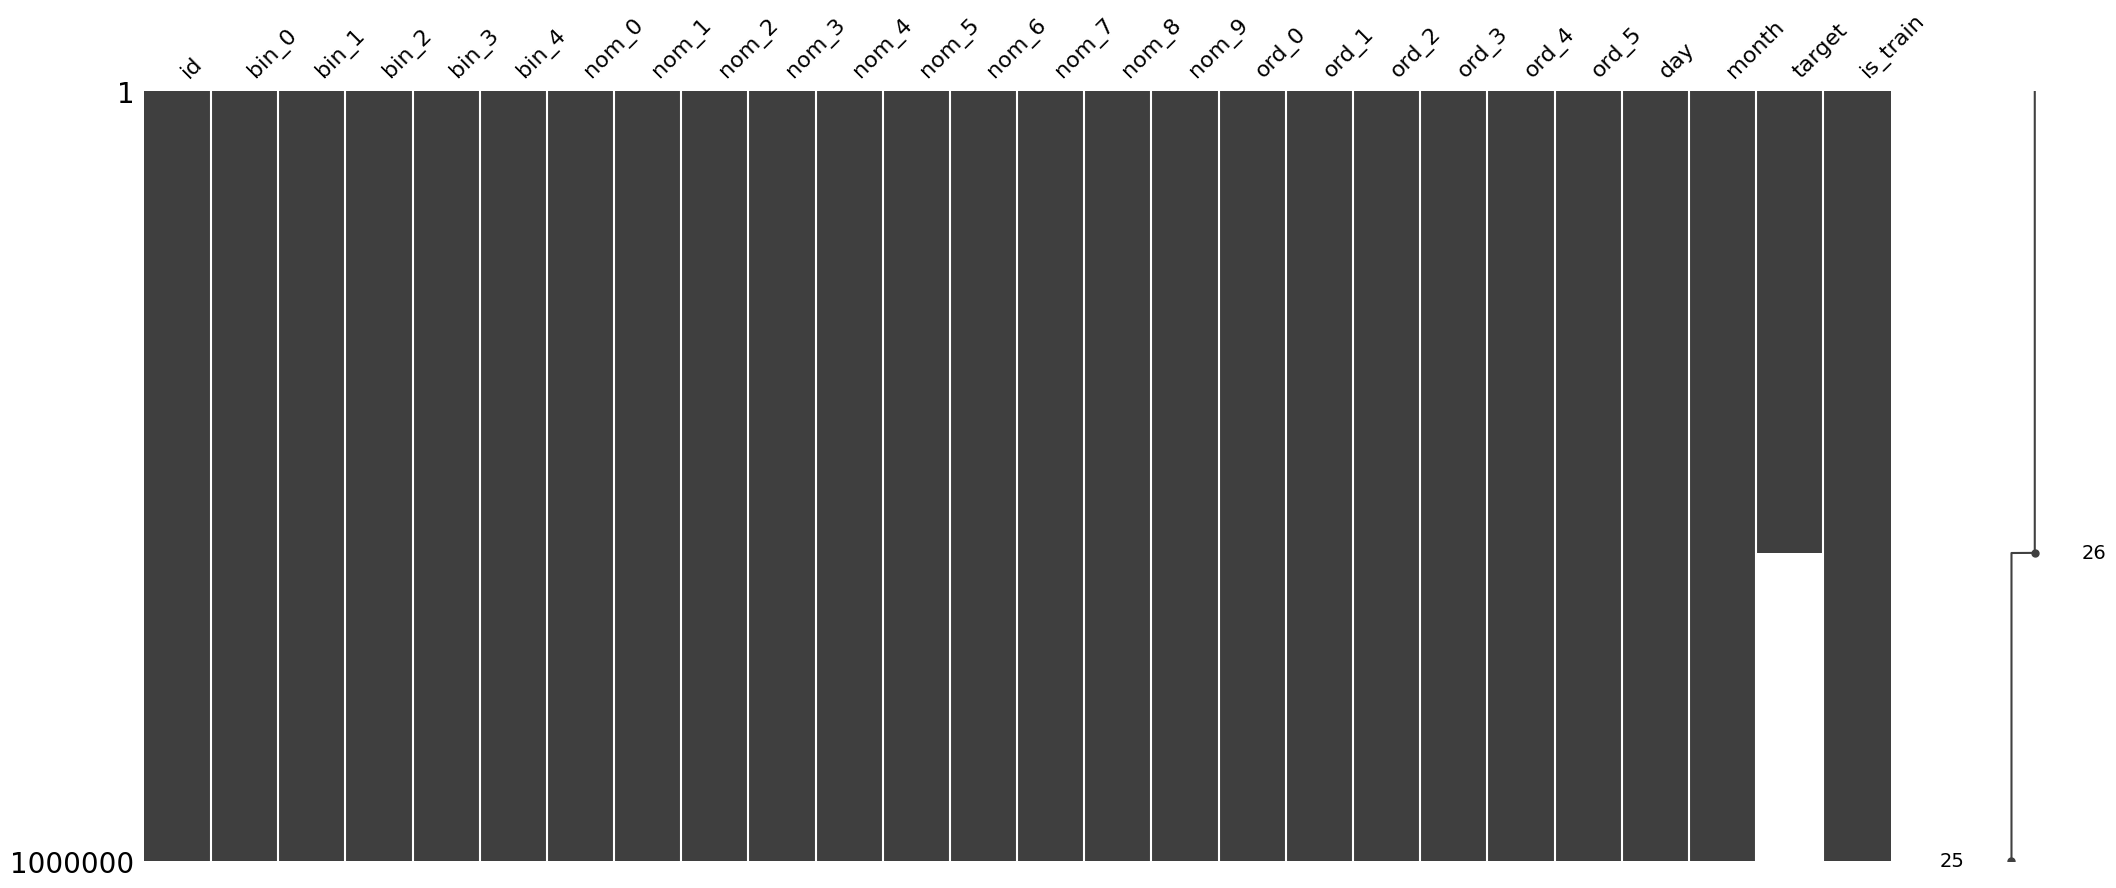

In [ ]:
msno.matrix(combined_final_df)

In [ ]:
combined_final_df.loc[combined_final_df['id'] <= 600000, 'is_train'].unique()

array([1, 0], dtype=int64)

In [ ]:
combined_final_df.head(10)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,is_train
0,0,0.0,0.0,0.0,0,0,Red,Trapezoid,Hamster,Russia,...,3.0,Contributor,Hot,2,20,56,6.0,3.0,0.0,1
1,1,1.0,1.0,0.0,0,1,Red,Star,Axolotl,India,...,3.0,Grandmaster,Warm,4,23,150,7.0,7.0,0.0,1
2,2,0.0,1.0,0.0,0,0,Red,Triangle,Hamster,Canada,...,3.0,Novice,Freezing,13,15,105,5.0,9.0,0.0,1
3,3,0.0,0.0,0.0,0,0,Red,Circle,Hamster,Finland,...,1.0,Novice,Lava Hot,0,2,Fl,3.0,3.0,0.0,1
4,4,0.0,0.0,0.0,1,0,Red,Triangle,Hamster,Costa Rica,...,3.0,Grandmaster,Cold,7,2,50,5.0,12.0,0.0,1
5,5,0.0,0.0,1.0,1,0,Red,Triangle,Lion,China,...,2.0,Expert,Hot,1,16,180,3.0,4.0,0.0,1
6,6,0.0,0.0,0.0,0,0,Red,Triangle,Hamster,Costa Rica,...,1.0,Grandmaster,Cold,2,17,158,5.0,6.0,0.0,1
7,7,0.0,0.0,1.0,1,0,Red,Triangle,Axolotl,Finland,...,3.0,Expert,Cold,1,24,54,1.0,1.0,0.0,1
8,8,0.0,0.0,0.0,0,0,Blue,Polygon,Hamster,Russia,...,1.0,Novice,Boiling Hot,2,13,136,6.0,3.0,0.0,1
9,9,0.0,0.0,0.0,0,1,Red,Polygon,Hamster,Finland,...,3.0,Contributor,Lava Hot,13,8,50,1.0,8.0,1.0,1


## Encoding variables

### Label encoding of bin_3 and bin_4

In [ ]:
binary_mapping = {'T': 1, 'F': 0, 'Y': 1, 'N': 0}


In [ ]:
combined_final_df['bin_3'] = combined_final_df['bin_3'].map(binary_mapping)
combined_final_df['bin_4'] = combined_final_df['bin_4'].map(binary_mapping)


In [ ]:
combined_final_df['bin_3'].value_counts()

bin_3
0    640269
1    359731
Name: count, dtype: int64

In [ ]:
combined_final_df[nominal_features].head()

,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9
0,Red,Trapezoid,Hamster,Russia,Bassoon,1059,1013,87,1,27
1,Red,Star,Axolotl,India,Theremin,210,359,27,69,2112
2,Red,Triangle,Hamster,Canada,Bassoon,860,694,90,102,8f3276a6e
3,Red,Circle,Hamster,Finland,Theremin,477,241,51,170,2167
4,Red,Triangle,Hamster,Costa Rica,Theremin,556,361,182,7d7c02c57,1747


In [ ]:
feature_summary = pd.DataFrame({
    'missing_rate': combined_final_df.isna().mean(),
    'unique_values': combined_final_df.nunique(),
    'dtype': combined_final_df.dtypes
})

feature_groups = {
    'binary': [col for col in combined_final_df.columns if col.startswith('bin_')],
    'nominal': [col for col in combined_final_df.columns if col.startswith('nom_')],
    'ordinal': ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5'],
    'other': ['id', 'day', 'month', 'target']
}

for group, cols in feature_groups.items():
    print(f"\n{group.upper()} FEATURES:")
    print(feature_summary.loc[cols])


BINARY FEATURES:
       missing_rate  unique_values    dtype
bin_0           0.0              2  float64
bin_1           0.0              2  float64
bin_2           0.0              2  float64
bin_3           0.0              2    int64
bin_4           0.0              2    int64

NOMINAL FEATURES:
       missing_rate  unique_values   dtype
nom_0           0.0              3  object
nom_1           0.0              6  object
nom_2           0.0              6  object
nom_3           0.0              6  object
nom_4           0.0              4  object
nom_5           0.0           1222  object
nom_6           0.0           1521  object
nom_7           0.0            224  object
nom_8           0.0            224  object
nom_9           0.0           2220  object

ORDINAL FEATURES:
       missing_rate  unique_values   dtype
ord_0           0.0              3  object
ord_1           0.0              5  object
ord_2           0.0              6  object
ord_3           0.0             16 

### Encoding nominal features

In [ ]:
combined_final_df['nom_0'].unique()

array(['Red', 'Blue', 'Green'], dtype=object)

In [ ]:
combined_df = combined_final_df.copy()

In [ ]:
combined_final_df = combined_df.copy()

In [ ]:
combined_final_df = pd.get_dummies(combined_final_df, columns=['nom_0'], drop_first=False)
for col in combined_final_df.columns:
    if col.startswith('nom_0_'):
        combined_final_df[col] = combined_final_df[col].astype(int)
        combined_final_df[col] = combined_final_df[col].astype(int)


In [ ]:
combined_final_df.head(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_1,nom_2,nom_3,nom_4,...,ord_3,ord_4,ord_5,day,month,target,is_train,nom_0_Blue,nom_0_Green,nom_0_Red
0,0,0.0,0.0,0.0,0,0,Trapezoid,Hamster,Russia,Bassoon,...,2,20,56,6.0,3.0,0.0,1,0,0,1
1,1,1.0,1.0,0.0,0,1,Star,Axolotl,India,Theremin,...,4,23,150,7.0,7.0,0.0,1,0,0,1
2,2,0.0,1.0,0.0,0,0,Triangle,Hamster,Canada,Bassoon,...,13,15,105,5.0,9.0,0.0,1,0,0,1
3,3,0.0,0.0,0.0,0,0,Circle,Hamster,Finland,Theremin,...,0,2,Fl,3.0,3.0,0.0,1,0,0,1
4,4,0.0,0.0,0.0,1,0,Triangle,Hamster,Costa Rica,Theremin,...,7,2,50,5.0,12.0,0.0,1,0,0,1


In [ ]:
combined_final_df["nom_1"].unique()

array(['Trapezoid', 'Star', 'Triangle', 'Circle', 'Polygon', 'Square'],
      dtype=object)

In [ ]:
combined_final_df = pd.get_dummies(combined_final_df, columns=['nom_1'], drop_first=False)
for col in combined_final_df.columns:
    if col.startswith('nom_1_'):
        combined_final_df[col] = combined_final_df[col].astype(int)
        combined_final_df[col] = combined_final_df[col].astype(int)

combined_final_df.head(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_2,nom_3,nom_4,nom_5,...,is_train,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle
0,0,0.0,0.0,0.0,0,0,Hamster,Russia,Bassoon,1059,...,1,0,0,1,0,0,0,0,1,0
1,1,1.0,1.0,0.0,0,1,Axolotl,India,Theremin,210,...,1,0,0,1,0,0,0,1,0,0
2,2,0.0,1.0,0.0,0,0,Hamster,Canada,Bassoon,860,...,1,0,0,1,0,0,0,0,0,1
3,3,0.0,0.0,0.0,0,0,Hamster,Finland,Theremin,477,...,1,0,0,1,1,0,0,0,0,0
4,4,0.0,0.0,0.0,1,0,Hamster,Costa Rica,Theremin,556,...,1,0,0,1,0,0,0,0,0,1


In [ ]:
combined_final_df["nom_2"].unique()

array(['Hamster', 'Axolotl', 'Lion', 'Dog', 'Cat', 'Snake'], dtype=object)

In [ ]:
combined_final_df.head(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_3,nom_4,nom_5,nom_6,...,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake
0,0,0.0,0.0,0.0,0,0,Russia,Bassoon,1059,1013,...,0,0,1,0,0,0,0,1,0,0
1,1,1.0,1.0,0.0,0,1,India,Theremin,210,359,...,0,1,0,0,1,0,0,0,0,0
2,2,0.0,1.0,0.0,0,0,Canada,Bassoon,860,694,...,0,0,0,1,0,0,0,1,0,0
3,3,0.0,0.0,0.0,0,0,Finland,Theremin,477,241,...,0,0,0,0,0,0,0,1,0,0
4,4,0.0,0.0,0.0,1,0,Costa Rica,Theremin,556,361,...,0,0,0,1,0,0,0,1,0,0


In [ ]:
for col in combined_final_df.columns:
    if col.startswith('nom_2_'):
        combined_final_df[col] = combined_final_df[col].astype(int)
        combined_final_df[col] = combined_final_df[col].astype(int)

In [ ]:
combined_final_df = pd.get_dummies(combined_final_df, columns=['nom_4'], drop_first=False)
for col in combined_final_df.columns:
    if col.startswith('nom_4_'):
        combined_final_df[col] = combined_final_df[col].astype(int)
        combined_final_df[col] = combined_final_df[col].astype(int)
combined_final_df.head(5)


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_3,nom_5,nom_6,nom_7,...,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_4_Bassoon,nom_4_Oboe,nom_4_Piano,nom_4_Theremin
0,0,0.0,0.0,0.0,0,0,Russia,1059,1013,87,...,0,0,0,1,0,0,1,0,0,0
1,1,1.0,1.0,0.0,0,1,India,210,359,27,...,1,0,0,0,0,0,0,0,0,1
2,2,0.0,1.0,0.0,0,0,Canada,860,694,90,...,0,0,0,1,0,0,1,0,0,0
3,3,0.0,0.0,0.0,0,0,Finland,477,241,51,...,0,0,0,1,0,0,0,0,0,1
4,4,0.0,0.0,0.0,1,0,Costa Rica,556,361,182,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
combined_final_df["nom_3"].unique()

array(['Russia', 'India', 'Canada', 'Finland', 'Costa Rica', 'China'],
      dtype=object)

In [ ]:
combined_final_df = pd.get_dummies(combined_final_df, columns=['nom_3'], drop_first=False)
for col in combined_final_df.columns:
    if col.startswith('nom_3_'):
        combined_final_df[col] = combined_final_df[col].astype(int)
        combined_final_df[col] = combined_final_df[col].astype(int)

combined_final_df.head(5)


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,...,nom_4_Bassoon,nom_4_Oboe,nom_4_Piano,nom_4_Theremin,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia
0,0,0.0,0.0,0.0,0,0,1059,1013,87,1,...,1,0,0,0,0,0,0,0,0,1
1,1,1.0,1.0,0.0,0,1,210,359,27,69,...,0,0,0,1,0,0,0,0,1,0
2,2,0.0,1.0,0.0,0,0,860,694,90,102,...,1,0,0,0,1,0,0,0,0,0
3,3,0.0,0.0,0.0,0,0,477,241,51,170,...,0,0,0,1,0,0,0,1,0,0
4,4,0.0,0.0,0.0,1,0,556,361,182,7d7c02c57,...,0,0,0,1,0,0,1,0,0,0


In [ ]:
combined_final_df["nom_5"].unique()

array([1059, 210, 860, ..., 1023, 227, 'e32171484'], dtype=object)

In [ ]:
combined_final_df["nom_5"].value_counts()

nom_5
fc8fc7e56    17778
e32171484    11912
257           1633
845           1597
185           1591
             ...  
657             16
523             13
227              8
546              6
12               4
Name: count, Length: 1222, dtype: int64

In [ ]:
combined_final_df["nom_5"] = combined_final_df["nom_5"].astype(str)
freq_map = combined_final_df["nom_5"].value_counts(normalize=True).to_dict()
combined_final_df["nom_5_freq"] = combined_final_df["nom_5"].map(freq_map)
combined_final_df.drop(columns=["nom_5"], inplace=True)
combined_final_df.head(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_6,nom_7,nom_8,nom_9,...,nom_4_Oboe,nom_4_Piano,nom_4_Theremin,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_5_freq
0,0,0.0,0.0,0.0,0,0,1013,87,1,27,...,0,0,0,0,0,0,0,0,1,0.000796
1,1,1.0,1.0,0.0,0,1,359,27,69,2112,...,0,0,1,0,0,0,0,1,0,0.001146
2,2,0.0,1.0,0.0,0,0,694,90,102,8f3276a6e,...,0,0,0,1,0,0,0,0,0,0.000725
3,3,0.0,0.0,0.0,0,0,241,51,170,2167,...,0,0,1,0,0,0,1,0,0,0.001053
4,4,0.0,0.0,0.0,1,0,361,182,7d7c02c57,1747,...,0,0,1,0,0,1,0,0,0,0.001401


In [ ]:
combined_final_df["nom_6"] = combined_final_df["nom_6"].astype(str)
freq_map = combined_final_df["nom_6"].value_counts(normalize=True).to_dict()
combined_final_df["nom_6_freq"] = combined_final_df["nom_6"].map(freq_map)
combined_final_df.drop(columns=["nom_6"], inplace=True)
combined_final_df.head(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_7,nom_8,nom_9,ord_0,...,nom_4_Piano,nom_4_Theremin,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_5_freq,nom_6_freq
0,0,0.0,0.0,0.0,0,0,87,1,27,3.0,...,0,0,0,0,0,0,0,1,0.000796,0.000531
1,1,1.0,1.0,0.0,0,1,27,69,2112,3.0,...,0,1,0,0,0,0,1,0,0.001146,0.000594
2,2,0.0,1.0,0.0,0,0,90,102,8f3276a6e,3.0,...,0,0,1,0,0,0,0,0,0.000725,0.001092
3,3,0.0,0.0,0.0,0,0,51,170,2167,1.0,...,0,1,0,0,0,1,0,0,0.001053,0.001056
4,4,0.0,0.0,0.0,1,0,182,7d7c02c57,1747,3.0,...,0,1,0,0,1,0,0,0,0.001401,0.000341


In [ ]:
combined_final_df["nom_9"] = combined_final_df["nom_9"].astype(str)
freq_map = combined_final_df["nom_9"].value_counts(normalize=True).to_dict()
combined_final_df["nom_9_freq"] = combined_final_df["nom_9"].map(freq_map)
combined_final_df.drop(columns=["nom_9"], inplace=True)
combined_final_df.head(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_7,nom_8,ord_0,ord_1,...,nom_4_Theremin,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_5_freq,nom_6_freq,nom_9_freq
0,0,0.0,0.0,0.0,0,0,87,1,3.0,Contributor,...,0,0,0,0,0,0,1,0.000796,0.000531,0.000323
1,1,1.0,1.0,0.0,0,1,27,69,3.0,Grandmaster,...,1,0,0,0,0,1,0,0.001146,0.000594,0.000850
2,2,0.0,1.0,0.0,0,0,90,102,3.0,Novice,...,0,1,0,0,0,0,0,0.000725,0.001092,0.018073
3,3,0.0,0.0,0.0,0,0,51,170,1.0,Novice,...,1,0,0,0,1,0,0,0.001053,0.001056,0.000393
4,4,0.0,0.0,0.0,1,0,182,7d7c02c57,3.0,Grandmaster,...,1,0,0,1,0,0,0,0.001401,0.000341,0.000781


In [ ]:
combined_final_df['nom_7'].unique()

array([87, 27, 90, 51, 182, 138, 25, 124, 64, 84, 149, 7, 15, 180, 219,
       145, 91, 206, 26, '4ae48e857', 101, 191, 218, 106, 184, 102, 162,
       67, 156, 172, 159, 181, 197, 170, 43, 66, 117, 70, 118, 13, 72, 60,
       4, 73, 100, 81, 24, 169, 203, 2, 142, 53, 208, 127, 36, 28, 153,
       155, 186, 58, 220, 111, 198, 78, 128, 216, 99, 52, 39, 214, 62,
       151, 93, 47, 157, 194, 17, 207, 29, 92, 137, 61, 174, 12, 79, 22,
       164, 135, 205, 126, 5, 165, 21, 48, 0, 129, 108, 10, 83, 131, 210,
       122, 105, 37, 150, 148, 30, 50, 55, 179, 143, 20, 97, 158, 56, 11,
       85, 57, 49, 9, 120, 82, 69, 185, 154, 146, 107, 115, 139, 178, 144,
       77, 161, 187, 168, 110, 103, 133, 104, 3, 88, 125, 94, 190, 134,
       98, 38, 31, 189, 221, 40, 215, 41, 192, 136, 45, 212, 200, 119, 95,
       130, 152, 116, 33, 188, 1, 42, 68, 175, 195, 23, 176, 213, 132,
       196, 140, 75, 76, 32, 35, 14, 63, 171, 114, 96, 19, 163, 65, 6, 34,
       141, 123, 167, 177, 74, 80, 112, 8, 211, 

In [ ]:
combined_final_df["nom_7"] = pd.to_numeric(combined_final_df["nom_7"], errors='coerce')
combined_final_df = combined_final_df.dropna(subset=["nom_7"])
mean_value = combined_final_df["nom_7"].mean()
combined_final_df["nom_7"] = combined_final_df["nom_7"].fillna(mean_value)


In [ ]:
combined_final_df['nom_7'].unique()

array([ 87.,  27.,  90.,  51., 182., 138.,  25., 124.,  64.,  84., 149.,
         7.,  15., 180., 219., 145.,  91., 206.,  26., 101., 191., 218.,
       106., 184., 102., 162.,  67., 156., 172., 159., 181., 197., 170.,
        43.,  66., 117.,  70., 118.,  13.,  72.,  60.,   4.,  73., 100.,
        81.,  24., 169., 203.,   2., 142.,  53., 208., 127.,  36.,  28.,
       153., 155., 186.,  58., 220., 111., 198.,  78., 128., 216.,  99.,
        52.,  39., 214.,  62., 151.,  93.,  47., 157., 194.,  17., 207.,
        29.,  92., 137.,  61., 174.,  12.,  79.,  22., 164., 135., 205.,
       126.,   5., 165.,  21.,  48.,   0., 129., 108.,  10.,  83., 131.,
       210., 122., 105.,  37., 150., 148.,  30.,  50.,  55., 179., 143.,
        20.,  97., 158.,  56.,  11.,  85.,  57.,  49.,   9., 120.,  82.,
        69., 185., 154., 146., 107., 115., 139., 178., 144.,  77., 161.,
       187., 168., 110., 103., 133., 104.,   3.,  88., 125.,  94., 190.,
       134.,  98.,  38.,  31., 189., 221.,  40., 21

In [ ]:
combined_final_df['nom_8'].unique()

array([1, 69, 102, 170, '7d7c02c57', 93, 167, 169, 138, 2, 35, 103, 81,
       203, 151, 185, 77, 196, 16, 198, 191, 75, 32, 33, 174, 61, 183, 71,
       22, 88, 155, 184, 86, 57, 110, 168, 83, 194, 55, 112, 27, 162, 139,
       8, 173, 52, 205, 153, 157, 79, 117, 119, 76, 133, 127, 147, 165,
       142, 111, 137, 187, 73, 20, 163, 149, 106, 107, 193, 212, 36, 63,
       148, 213, 166, 12, 4, 220, 140, 216, 208, 150, 13, 43, 74, 68, 143,
       78, 197, 120, 59, 7, 160, 130, 176, 30, 115, 118, 14, 62, 154, 136,
       188, 54, 40, 66, 186, 31, 189, 21, 204, 6, 23, 97, 211, 134, 44,
       159, 104, 141, 202, 178, 123, 128, 156, 181, 45, 164, 192, 70, 221,
       126, 49, 26, 82, 91, 3, 217, 65, 158, 101, 190, 99, 219, 161, 195,
       67, 80, 214, 95, 41, 179, 109, 98, 114, 105, 11, 116, 94, 47, 206,
       38, 132, 56, 200, 172, 25, 0, 5, 182, 17, 108, 180, 207, 24, 131,
       29, 87, 46, 152, 175, 34, 210, 215, 19, 218, 60, 90, 64, 85, 113,
       96, 100, 39, 209, 42, 125, 177, 145

In [ ]:
combined_final_df["nom_8"] = pd.to_numeric(combined_final_df["nom_8"], errors='coerce')
combined_final_df = combined_final_df.dropna(subset=["nom_8"])
mean_value = combined_final_df["nom_8"].mean()
combined_final_df["nom_8"] = combined_final_df["nom_8"].fillna(mean_value)

In [ ]:
combined_final_df['nom_8'].unique()

array([  1.,  69., 102., 170.,  93., 167., 169., 138.,   2.,  35., 103.,
        81., 203., 151., 185.,  77., 196.,  16., 198., 191.,  75.,  32.,
        33., 174.,  61., 183.,  71.,  22.,  88., 155., 184.,  86.,  57.,
       110., 168.,  83., 194.,  55., 112.,  27., 162., 139.,   8., 173.,
        52., 205., 153., 157.,  79., 117., 119.,  76., 133., 127., 147.,
       165., 142., 111., 137., 187.,  73.,  20., 163., 149., 106., 107.,
       193., 212.,  36.,  63., 148., 213., 166.,  12.,   4., 220., 140.,
       216., 208., 150.,  13.,  43.,  74.,  68., 143.,  78., 197., 120.,
        59.,   7., 160., 130., 176.,  30., 115., 118.,  14.,  62., 154.,
       136., 188.,  54.,  40.,  66., 186.,  31., 189.,  21., 204.,   6.,
        23.,  97., 211., 134.,  44., 159., 104., 141., 202., 178., 123.,
       128., 156., 181.,  45., 164., 192.,  70., 221., 126.,  49.,  26.,
        82.,  91.,   3., 217.,  65., 158., 101., 190.,  99., 219., 161.,
       195.,  67.,  80., 214.,  95.,  41., 179., 10

In [ ]:
combined_final_df.head(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_7,nom_8,ord_0,ord_1,...,nom_4_Theremin,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_5_freq,nom_6_freq,nom_9_freq
0,0,0.0,0.0,0.0,0,0,87.0,1.0,3.0,Contributor,...,0,0,0,0,0,0,1,0.000796,0.000531,0.000323
1,1,1.0,1.0,0.0,0,1,27.0,69.0,3.0,Grandmaster,...,1,0,0,0,0,1,0,0.001146,0.000594,0.000850
2,2,0.0,1.0,0.0,0,0,90.0,102.0,3.0,Novice,...,0,1,0,0,0,0,0,0.000725,0.001092,0.018073
3,3,0.0,0.0,0.0,0,0,51.0,170.0,1.0,Novice,...,1,0,0,0,1,0,0,0.001053,0.001056,0.000393
5,5,0.0,0.0,1.0,1,0,138.0,93.0,2.0,Expert,...,0,0,1,0,0,0,0,0.001516,0.001097,0.000658


### Encoding ordinal features

In [ ]:
feature_summary = pd.DataFrame({
    'missing_rate': combined_final_df.isna().mean(),
    'unique_values': combined_final_df.nunique(),
    'dtype': combined_final_df.dtypes
})

feature_groups = {
    'binary': [col for col in combined_final_df.columns if col.startswith('bin_')],
    'nominal': [col for col in combined_final_df.columns if col.startswith('nom_')],
    'ordinal': ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5'],
    'other': ['id', 'day', 'month', 'target']
}

for group, cols in feature_groups.items():
    print(f"\n{group.upper()} FEATURES:")
    print(feature_summary.loc[cols])


BINARY FEATURES:
       missing_rate  unique_values    dtype
bin_0           0.0              2  float64
bin_1           0.0              2  float64
bin_2           0.0              2  float64
bin_3           0.0              2    int64
bin_4           0.0              2    int64

NOMINAL FEATURES:
                  missing_rate  unique_values    dtype
nom_7                      0.0            222  float64
nom_8                      0.0            222  float64
nom_0_Blue                 0.0              2    int32
nom_0_Green                0.0              2    int32
nom_0_Red                  0.0              2    int32
nom_1_Circle               0.0              2    int32
nom_1_Polygon              0.0              2    int32
nom_1_Square               0.0              2    int32
nom_1_Star                 0.0              2    int32
nom_1_Trapezoid            0.0              2    int32
nom_1_Triangle             0.0              2    int32
nom_2_Axolotl              0.0         

In [ ]:
combined_final_df.head(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_7,nom_8,ord_0,ord_1,...,nom_4_Theremin,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_5_freq,nom_6_freq,nom_9_freq
0,0,0.0,0.0,0.0,0,0,87.0,1.0,3.0,Contributor,...,0,0,0,0,0,0,1,0.000796,0.000531,0.000323
1,1,1.0,1.0,0.0,0,1,27.0,69.0,3.0,Grandmaster,...,1,0,0,0,0,1,0,0.001146,0.000594,0.000850
2,2,0.0,1.0,0.0,0,0,90.0,102.0,3.0,Novice,...,0,1,0,0,0,0,0,0.000725,0.001092,0.018073
3,3,0.0,0.0,0.0,0,0,51.0,170.0,1.0,Novice,...,1,0,0,0,1,0,0,0.001053,0.001056,0.000393
5,5,0.0,0.0,1.0,1,0,138.0,93.0,2.0,Expert,...,0,0,1,0,0,0,0,0.001516,0.001097,0.000658


In [ ]:
combined_final_df["ord_0"].unique()

array([3.0, 1.0, 2.0], dtype=object)

In [ ]:
combined_final_df["ord_1"].unique()

array(['Contributor', 'Grandmaster', 'Novice', 'Expert', 'Master'],
      dtype=object)

In [ ]:
ordinal_mapping = {
    'Novice': 0,
    'Contributor': 1,
    'Expert': 2,
    'Master': 3,
    'Grandmaster': 4
}
combined_final_df["ord_1"] = combined_final_df["ord_1"].map(ordinal_mapping)


In [ ]:
combined_final_df["ord_1"].unique()

array([1, 4, 0, 2, 3], dtype=int64)

In [ ]:
combined_final_df["ord_2"].unique()

array(['Hot', 'Warm', 'Freezing', 'Lava Hot', 'Cold', 'Boiling Hot'],
      dtype=object)

In [ ]:
ordinal_mapping_2 = {
    'Freezing': 0,
    'Cold': 1,
    'Warm': 2,
    'Hot': 3,
    'Boiling Hot': 4,
    'Lava Hot': 5
}
combined_final_df["ord_2"] = combined_final_df["ord_2"].map(ordinal_mapping_2)


In [ ]:
combined_final_df["ord_2"].unique()

array([3, 2, 0, 5, 1, 4], dtype=int64)

In [ ]:
combined_final_df["ord_3"].unique()

array([2, 4, 13, 0, 1, 7, 3, 10, 6, 14, 8, 12, 'n', 5, 11, 9],
      dtype=object)

In [ ]:
combined_final_df['ord_3'] = pd.to_numeric(combined_final_df['ord_3'], errors='coerce')
mean_value = combined_final_df['ord_3'].mean()
combined_final_df['ord_3'] = combined_final_df['ord_3'].fillna(mean_value)


array([ 2.        ,  4.        , 13.        ,  0.        ,  1.        ,
        7.        ,  3.        , 10.        ,  6.        , 14.        ,
        8.        , 12.        ,  6.81340125,  5.        , 11.        ,
        9.        ])

In [ ]:
combined_final_df["ord_3"].sample(5)

231842    12.000000
227339     6.813401
64869      7.000000
555601    13.000000
232923     7.000000
Name: ord_3, dtype: float64

In [ ]:
combined_final_df["ord_4"].unique()

array([20, 23, 15, 2, 16, 17, 24, 13, 8, 14, 12, 4, 21, 6, 10, 1, 7, 'N',
       19, 0, 5, 22, 3, 18, 9, 11, 25], dtype=object)

In [ ]:
combined_final_df['ord_4'] = pd.to_numeric(combined_final_df['ord_4'], errors='coerce')
mean_value = combined_final_df['ord_4'].mean()
combined_final_df['ord_4'] = combined_final_df['ord_4'].fillna(round(mean_value))
combined_final_df["ord_4"].sample(5)

218628     8.0
137751     3.0
447568     5.0
72577      7.0
517962    13.0
Name: ord_4, dtype: float64

In [ ]:
combined_final_df["ord_4"].unique()

array([20., 23., 15.,  2., 16., 17., 24., 13.,  8., 14., 12.,  4., 21.,
        6., 10.,  1.,  7., 19.,  0.,  5., 22.,  3., 18.,  9., 11., 25.])

In [ ]:
combined_final_df["ord_5"].unique()

array([56, 150, 105, 'Fl', 180, 158, 54, 136, 50, 117, 182, 62, 48, 103,
       69, 49, 66, 121, 24, 29, 3, 137, 124, 78, 148, 139, 71, 163, 21,
       122, 79, 102, 60, 144, 12, 28, 147, 175, 173, 161, 165, 18, 1, 44,
       146, 15, 72, 8, 164, 83, 75, 138, 157, 55, 80, 61, 14, 26, 16, 142,
       101, 34, 84, 130, 73, 189, 86, 0, 82, 22, 42, 7, 89, 145, 187, 64,
       38, 32, 114, 37, 120, 33, 108, 177, 43, 133, 6, 92, 87, 70, 95,
       179, 156, 35, 154, 143, 129, 149, 162, 112, 17, 128, 97, 169, 11,
       118, 153, 166, 183, 47, 110, 132, 91, 5, 184, 2, 119, 96, 134, 172,
       109, 13, 63, 160, 67, 39, 30, 36, 99, 171, 31, 94, 159, 186, 88, 9,
       131, 181, 151, 115, 52, 23, 176, 4, 25, 74, 106, 51, 135, 98, 27,
       57, 77, 155, 140, 111, 178, 100, 188, 65, 45, 185, 81, 46, 90, 126,
       41, 127, 20, 107, 125, 116, 58, 10, 152, 141, 123, 76, 168, 85,
       170, 19, 167, 40, 59, 68, 53, 174, 104, 113, 93], dtype=object)

In [ ]:
combined_final_df['ord_5'] = pd.to_numeric(combined_final_df['ord_5'], errors='coerce')
mean_value = combined_final_df['ord_5'].mean()
combined_final_df['ord_5'] = combined_final_df['ord_5'].fillna(round(mean_value))
combined_final_df["ord_5"].unique()

array([ 56., 150., 105.,  91., 180., 158.,  54., 136.,  50., 117., 182.,
        62.,  48., 103.,  69.,  49.,  66., 121.,  24.,  29.,   3., 137.,
       124.,  78., 148., 139.,  71., 163.,  21., 122.,  79., 102.,  60.,
       144.,  12.,  28., 147., 175., 173., 161., 165.,  18.,   1.,  44.,
       146.,  15.,  72.,   8., 164.,  83.,  75., 138., 157.,  55.,  80.,
        61.,  14.,  26.,  16., 142., 101.,  34.,  84., 130.,  73., 189.,
        86.,   0.,  82.,  22.,  42.,   7.,  89., 145., 187.,  64.,  38.,
        32., 114.,  37., 120.,  33., 108., 177.,  43., 133.,   6.,  92.,
        87.,  70.,  95., 179., 156.,  35., 154., 143., 129., 149., 162.,
       112.,  17., 128.,  97., 169.,  11., 118., 153., 166., 183.,  47.,
       110., 132.,   5., 184.,   2., 119.,  96., 134., 172., 109.,  13.,
        63., 160.,  67.,  39.,  30.,  36.,  99., 171.,  31.,  94., 159.,
       186.,  88.,   9., 131., 181., 151., 115.,  52.,  23., 176.,   4.,
        25.,  74., 106.,  51., 135.,  98.,  27.,  5

In [ ]:
combined_final_df.head(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_7,nom_8,ord_0,ord_1,...,nom_4_Theremin,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_5_freq,nom_6_freq,nom_9_freq
0,0,0.0,0.0,0.0,0,0,87.0,1.0,3.0,1,...,0,0,0,0,0,0,1,0.000796,0.000531,0.000323
1,1,1.0,1.0,0.0,0,1,27.0,69.0,3.0,4,...,1,0,0,0,0,1,0,0.001146,0.000594,0.000850
2,2,0.0,1.0,0.0,0,0,90.0,102.0,3.0,0,...,0,1,0,0,0,0,0,0.000725,0.001092,0.018073
3,3,0.0,0.0,0.0,0,0,51.0,170.0,1.0,0,...,1,0,0,0,1,0,0,0.001053,0.001056,0.000393
5,5,0.0,0.0,1.0,1,0,138.0,93.0,2.0,2,...,0,0,1,0,0,0,0,0.001516,0.001097,0.000658


In [ ]:
feature_summary = pd.DataFrame({
    'missing_rate': combined_final_df.isna().mean(),
    'unique_values': combined_final_df.nunique(),
    'dtype': combined_final_df.dtypes
})

feature_groups = {
    'binary': [col for col in combined_final_df.columns if col.startswith('bin_')],
    'nominal': [col for col in combined_final_df.columns if col.startswith('nom_')],
    'ordinal': ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5'],
    'other': ['id', 'day', 'month', 'target']
}

for group, cols in feature_groups.items():
    print(f"\n{group.upper()} FEATURES:")
    print(feature_summary.loc[cols])


BINARY FEATURES:
       missing_rate  unique_values    dtype
bin_0           0.0              2  float64
bin_1           0.0              2  float64
bin_2           0.0              2  float64
bin_3           0.0              2    int64
bin_4           0.0              2    int64

NOMINAL FEATURES:
                  missing_rate  unique_values    dtype
nom_7                      0.0            222  float64
nom_8                      0.0            222  float64
nom_0_Blue                 0.0              2    int32
nom_0_Green                0.0              2    int32
nom_0_Red                  0.0              2    int32
nom_1_Circle               0.0              2    int32
nom_1_Polygon              0.0              2    int32
nom_1_Square               0.0              2    int32
nom_1_Star                 0.0              2    int32
nom_1_Trapezoid            0.0              2    int32
nom_1_Triangle             0.0              2    int32
nom_2_Axolotl              0.0         

In [ ]:
combined_final_df['ord_0'] = pd.to_numeric(combined_final_df['ord_0'], errors='coerce')
combined_final_df.head(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_7,nom_8,ord_0,ord_1,...,nom_4_Theremin,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_5_freq,nom_6_freq,nom_9_freq
0,0,0.0,0.0,0.0,0,0,87.0,1.0,3.0,1,...,0,0,0,0,0,0,1,0.000796,0.000531,0.000323
1,1,1.0,1.0,0.0,0,1,27.0,69.0,3.0,4,...,1,0,0,0,0,1,0,0.001146,0.000594,0.000850
2,2,0.0,1.0,0.0,0,0,90.0,102.0,3.0,0,...,0,1,0,0,0,0,0,0.000725,0.001092,0.018073
3,3,0.0,0.0,0.0,0,0,51.0,170.0,1.0,0,...,1,0,0,0,1,0,0,0.001053,0.001056,0.000393
5,5,0.0,0.0,1.0,1,0,138.0,93.0,2.0,2,...,0,0,1,0,0,0,0,0.001516,0.001097,0.000658


In [ ]:
final_df = combined_final_df.copy()

## Training the model

<Axes: >

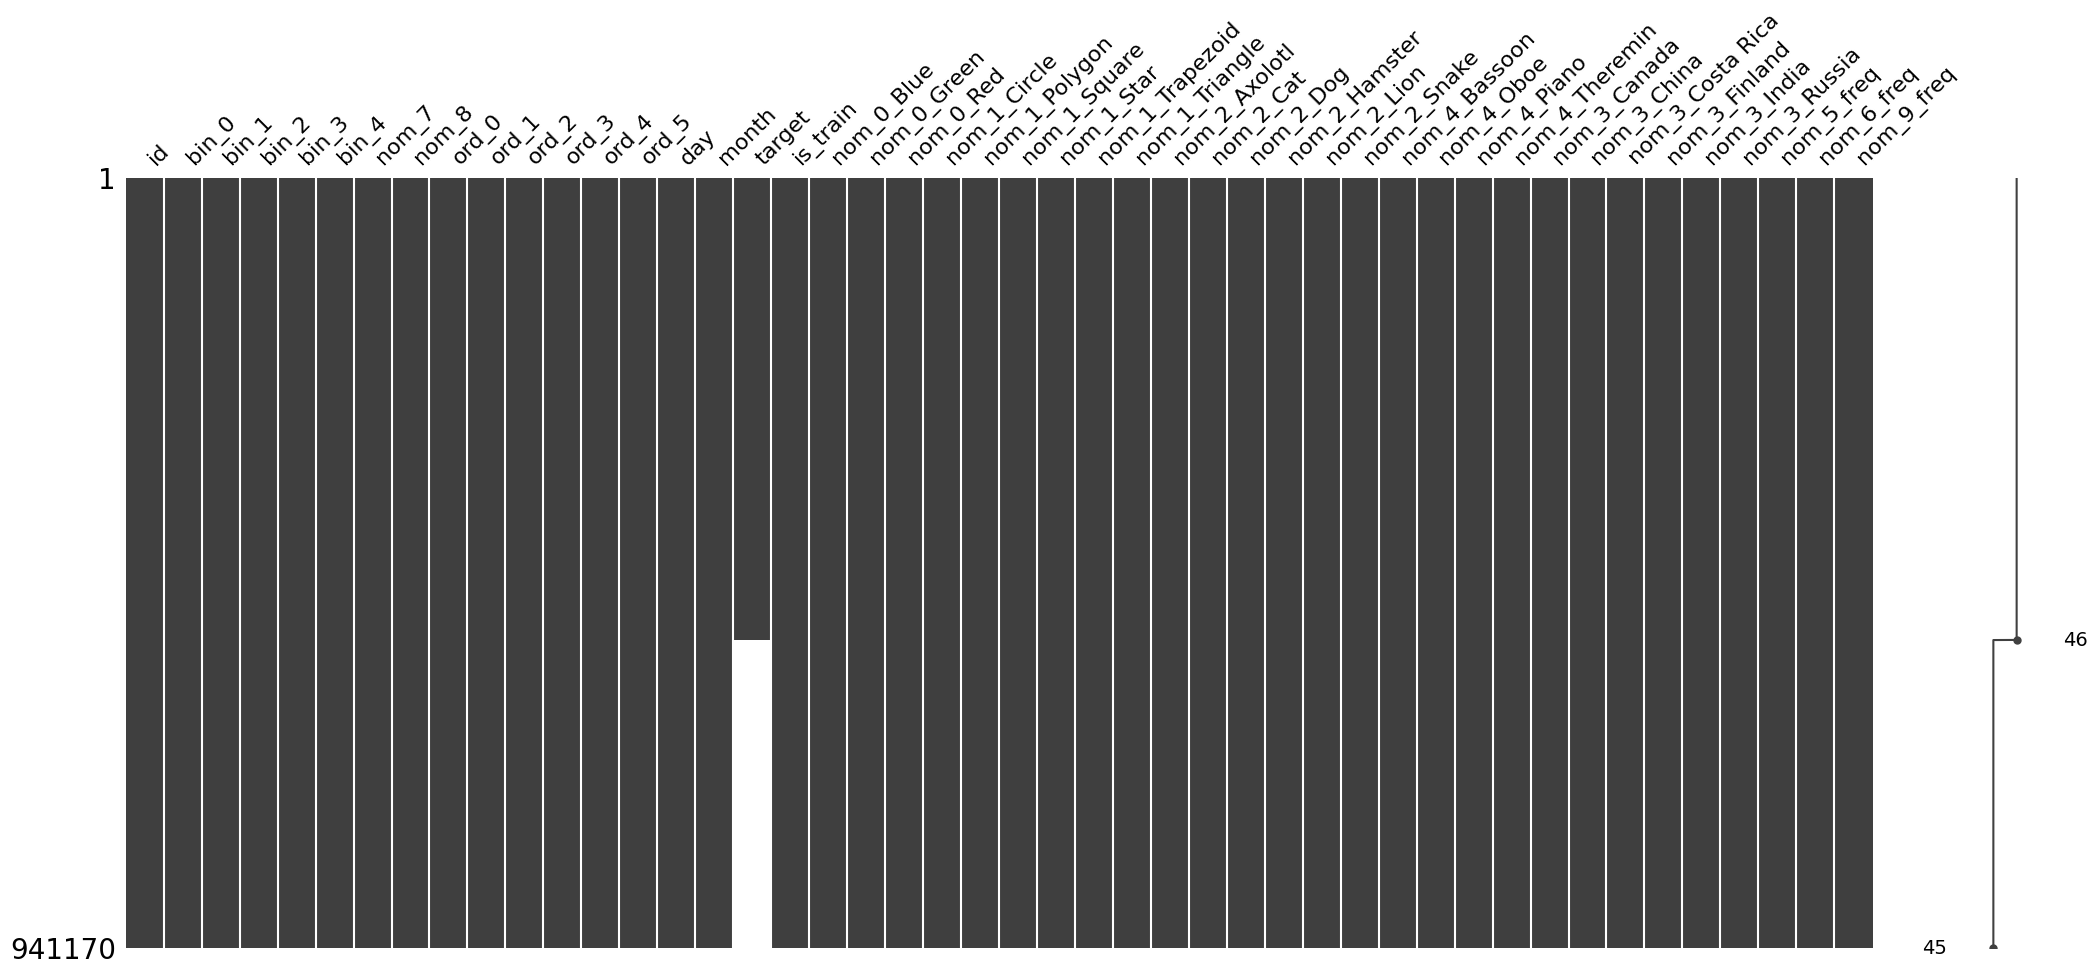

In [ ]:
msno.matrix(final_df)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import lightgbm
from sklearn.model_selection import train_test_split
def train_and_predict(df):
    """
    Complete pipeline for training the model and making predictions.

    Parameters:
    df (pandas.DataFrame): Combined dataframe with 'is_train' identifier

    Returns:
    tuple: (trained_model, predictions, validation_score)
    """
    # Split features by type
    binary_features = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']
    nominal_features = [col for col in df.columns if col.startswith('nom_')]
    ordinal_features = [col for col in df.columns if col.startswith('ord_')]
    time_features = ['day', 'month']

    # Combine all feature columns
    feature_columns = (binary_features + nominal_features +
                      ordinal_features + time_features)

    # Split back into train and test
    train_df = df[df['is_train'] == 1].copy()
    test_df = df[df['is_train'] == 0].copy()

    # Prepare training data
    X_train = train_df[feature_columns]
    y_train = train_df['target']

    # Prepare test data
    X_test = test_df[feature_columns]
    test_ids = test_df['id']

    # Create a validation set from training data
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    # Initialize model
    model = LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=32,
        random_state=42
    )

    # Train model
    print("Training model...")
    model.fit(
        X_train_final,
        y_train_final,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[
            lightgbm.early_stopping(stopping_rounds=50),
            lightgbm.log_evaluation(period=100)
        ]
    )

    # Validate model
    val_predictions = model.predict(X_val)
    val_score = accuracy_score(y_val, val_predictions)
    print("\nValidation Results:")
    print(f"Accuracy: {val_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, val_predictions))

    # Make predictions on test set
    print("\nMaking predictions on test set...")
    test_predictions = model.predict(X_test)
    test_probabilities = model.predict_proba(X_test)

    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': test_ids,
        'target': test_predictions,
        'probability': test_probabilities[:, 1]
    })

    print("\nSample of predictions:")
    print(submission_df.head())

    return model, submission_df, val_score

In [ ]:
model, predictions, validation_score = train_and_predict(final_df)


Training model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 84387, number of negative: 367420
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 451807, number of used features: 43
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.186777 -> initscore=-1.471092
[LightGBM] [Info] Start training from score -1.471092
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.751808	valid_0's binary_logloss: 0.421142
[200]	valid_0's auc: 0.762304	valid_0's binary_logloss: 0.413878
[300]	valid_0's auc: 0.767365	valid_0's binary_logloss: 0.410618
[400]	valid_0's auc: 0.769424	valid_0's binary_logloss: 0.409263
[500]

## Results

In [ ]:
predictions[['id', 'probability']].head(50)

,id,probability
0,600000,0.204164
1,600001,0.263003
2,600002,0.129263
3,600003,0.112652
4,600004,0.181526
5,600005,0.280064
6,600006,0.635225
7,600007,0.316689
8,600008,0.170509
9,600009,0.240401
